# Single Sample Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 07.09.2023

## 1. Setup

### 1.1 Import Libraries

In [9]:
%load_ext autoreload
%autoreload 2

In [10]:
import sys
sys.path.append("../../../nichecompass-reproducibility/utils")

In [11]:
import gc
import os
import shutil
import warnings
from datetime import datetime

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import numpy as np
import pandas as pd
import pickle
import plottable
import scanpy as sc
import scib_metrics

from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

from benchmarking_utils import *

### 1.2 Define Parameters

In [105]:
metric_cols_sample_integration = [
    "cas", "mlami", # global spatial conservation
    "clisis", "gcs", # local spatial conservation
    "nasw", "cnmi", # niche coherence
    "blisi" # batch correction
]
metric_col_weights_sample_integration = [ # separate for each category (later multiplied with category_col_weights)
    (1/2), (1/2), # global spatial conservation
    (1/2), (1/2), # local spatial conservation
    (1/2), (1/2), # niche clustering performance
    (1/2), # batch correction
]
metric_col_titles_sample_integration = [
    "CAS", # "Cell Type Affinity Similarity",
    "MLAMI", # "Maximum Leiden Adjusted Mutual Info",
    "CLISIS", # "Cell Type Local Inverse Simpson's Index Similarity",
    "GCS", # "Graph Connectivity Similarity",
    "NASW", # "Niche Average Silhouette Width",
    "CNMI", # "Cell Type Normalized Mutual Info",
    "BLISI" # "Batch Local Inverse Simpson's Index"
]
metric_cols_single_sample = metric_cols_sample_integration[:-1]
metric_col_weights_single_sample = metric_col_weights_sample_integration[:-1]
metric_col_titles_single_sample = metric_col_titles_sample_integration[:-1]

category_cols_sample_integration = [
    "Global Spatial Conservation Score",
    "Local Spatial Conservation Score",
    "Niche Coherence Score",
    "Batch Correction Score"]
category_col_weights_sample_integration = [
    1,
    1,
    1,
    1]
category_col_titles_sample_integration = [
    "Global Spatial Conservation Score",
    "Local Spatial Conservation Score",
    "Niche Coherence Score",
    "Batch Correction Score"]
category_col_weights_single_sample = category_col_weights_sample_integration[:-1]
category_cols_single_sample = category_cols_sample_integration[:-1]
category_col_titles_single_sample = [
    "Global Spatial Conservation Score",
    "Local Spatial Conservation Score",
    "Niche Coherence Score"]

### 1.3 Run Notebook Setup

In [31]:
sc.set_figure_params(figsize=(6, 6))

In [32]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [33]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

In [34]:
# Set mlflow tracking server (run it on the defined port)
mlflow.set_tracking_uri("http://localhost:8889")

### 1.4 Configure Paths and Directories

In [35]:
data_folder_path = "../../datasets/srt_data/gold"
artifact_folder_path = f"../../artifacts"
benchmarking_folder_path = f"{artifact_folder_path}/single_sample_method_benchmarking"

## 2. Method Benchmarking

- Run all model notebooks in the ```notebooks/single_sample_method_benchmarking``` directory before continuing.

### 2.1 Retrieve NicheCompass Runs

#### 2.1.1 seqFISH Mouse Organogenesis

#### 2.1.2 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

#### 2.1.4 Vizgen MERFISH Mouse Liver

#### 2.1.5 Slide-seqV2 Mouse Hippocampus

### 2.1 Create Benchmarking Metrics Plots & Run Time Plots

#### 2.1.1 Slide-seqV2 Mouse Hippocampus

In [106]:
datasets = ["slideseqv2_mouse_hippocampus"]
models = [#"nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "graphst",
          "deeplinc",
          "sagenet",
          #"scvi",
          #"expimap"
]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:2]], weights=metric_col_weights_single_sample[:2], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[2:4]], weights=metric_col_weights_single_sample[2:4], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[4:6]], weights=metric_col_weights_single_sample[4:6], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Filter for just second run
summary_df = summary_df[summary_df["run_number"] == 2]

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

unrolled_df["model"] = unrolled_df["model"].replace("NicheCompass GATv2", "NicheCompass")
#unrolled_df["model"] = unrolled_df["model"].replace("NicheCompass GCN", "Mini NicheCompass")

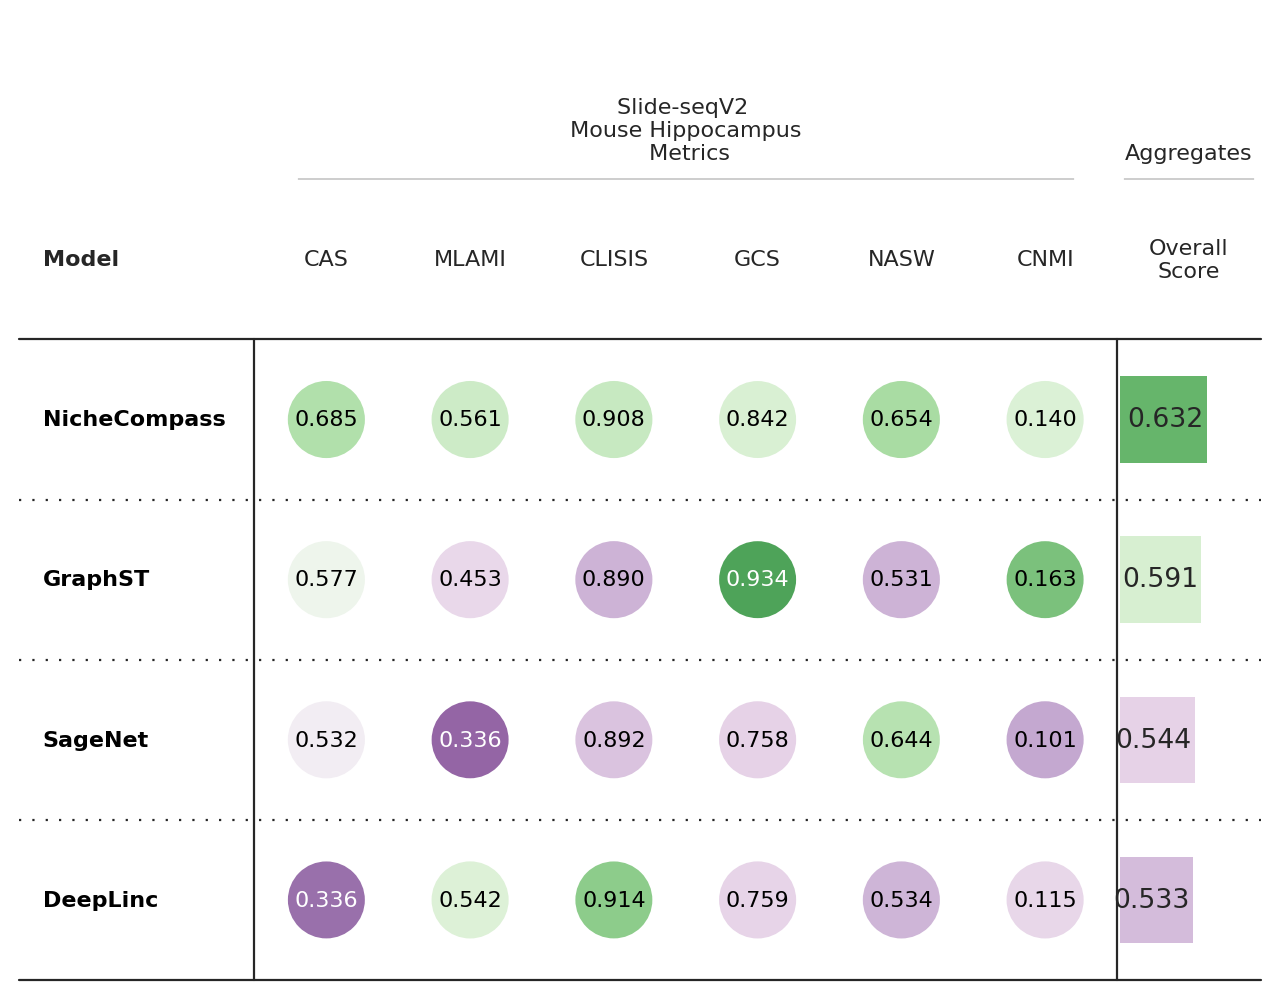

In [107]:
# Plot table
plot_simple_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=1.8,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=1.1, # 0.8,
    plot_width=10, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_slideseqv2_mouse_hippocampus_run2.svg")

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = [#"nichecompass_gatv2conv",
          #"graphst",
          #"sagenet",
          #"deeplinc",
          #"scvi",
          #"expimap"
         ]

run_number = 2
leiden_resolutions = [#0.35,
                      #0.93,
                      #0.0775,
                      #1.1,
                      #0.875,
                      #1.55
                     ]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")


Computing neighbor graph...


/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cartalop/minicon


Computing UMAP embedding...

Computing Leiden clustering...


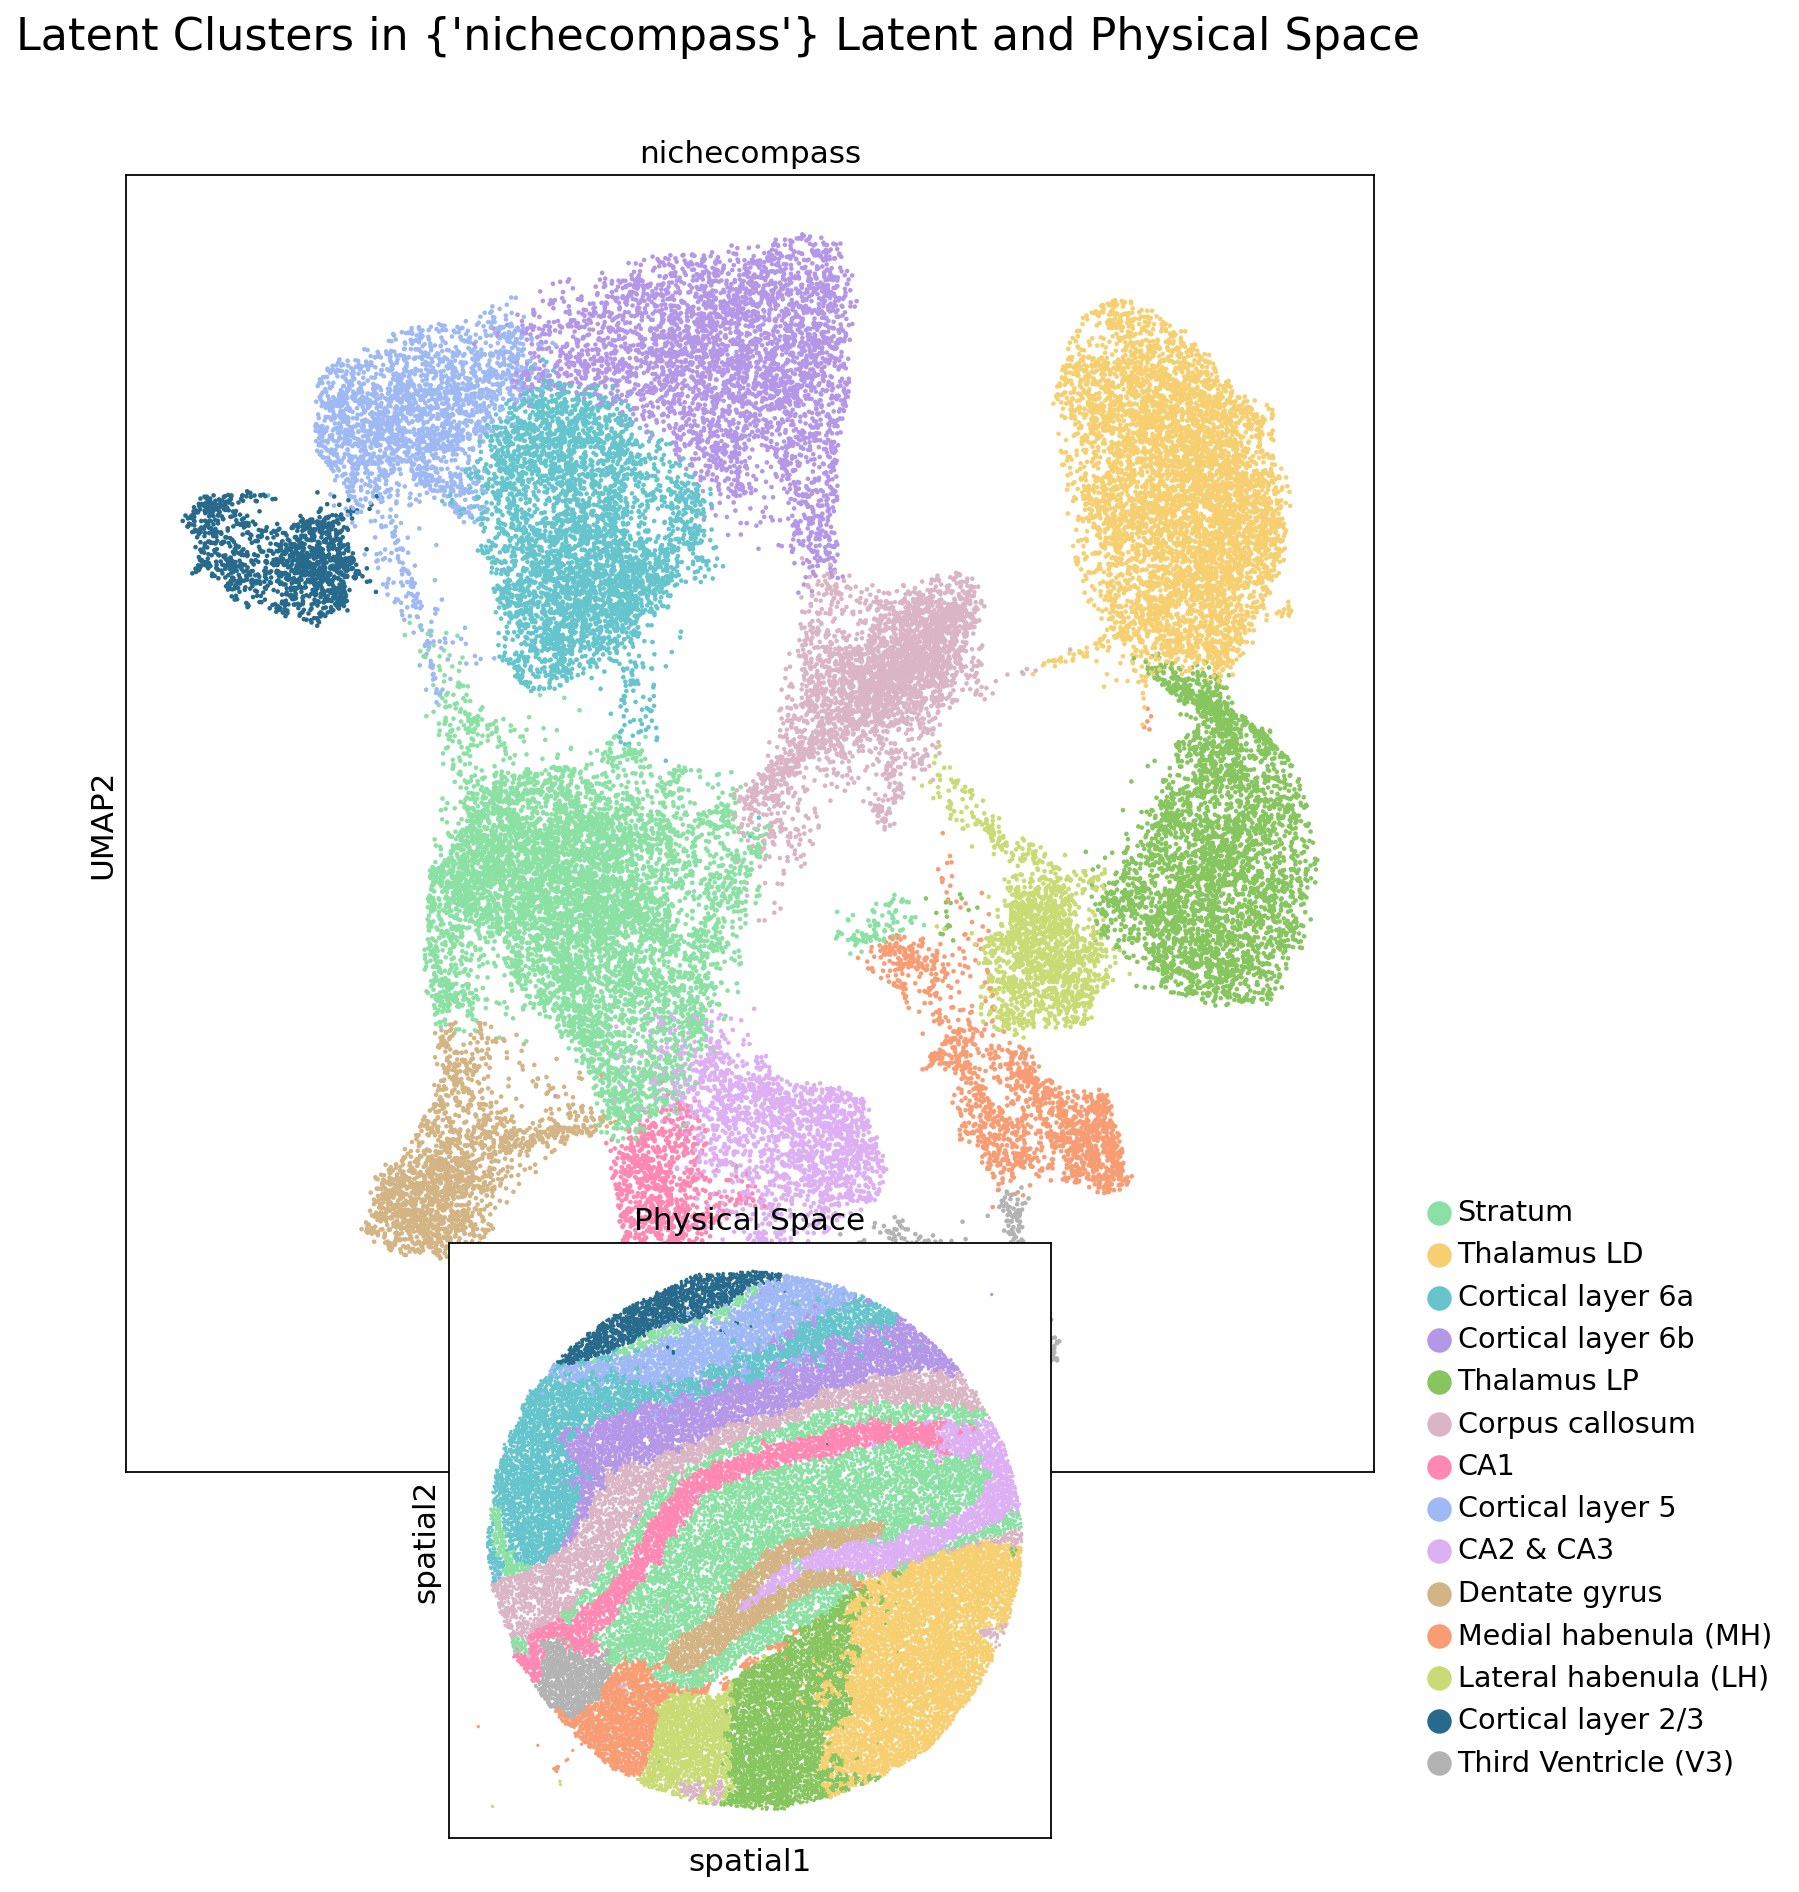

In [104]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["nichecompass_gatv2conv"]
run_number = 2
leiden_resolutions = [0.35]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    niche_annotations = {
        "0": "Stratum",
        "1": "Thalamus LD",
        "2": "Cortical layer 6a",
        "3": "Cortical layer 6b",
        "4": "Thalamus LP",
        "5": "Corpus callosum",
        "6": "CA1",
        "7": "Cortical layer 5",
        "8": "CA2 & CA3",
        "9": "Dentate gyrus",
        "10": "Medial habenula (MH)",
        "11": "Lateral habenula (LH)",
        "12": "Cortical layer 2/3",
        "13": "Third Ventricle (V3)"}

    adata.obs["niche"] = adata.obs["run2_leiden_0.35"].map(niche_annotations)

    latent_cluster_colors = create_new_color_dict(
        adata=adata,
        cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}")
    
    niche_colors = {niche: latent_cluster_colors[cluster] for cluster, niche in niche_annotations.items()}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"niche",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=niche_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

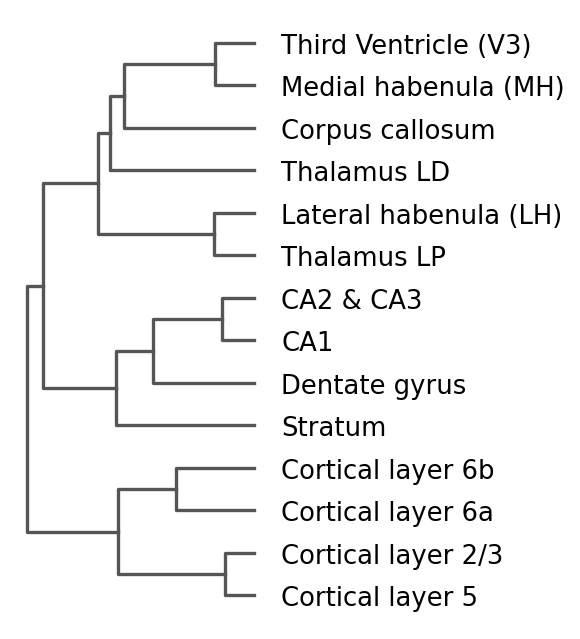

In [105]:
sc.tl.dendrogram(adata=adata,
                 use_rep="nichecompass_latent_run2",
                 linkage_method="ward",
                 groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(2, 5))
sc.pl.dendrogram(
    adata=adata,
    groupby="niche",
    orientation="left",
    show=False,
    ax=ax)
plt.show()

In [108]:
adata.obs

cell_type   sample run2_leiden_0.35  \
AACGTCATAATCGT           DentatePyramids  sample1                2   
TACTTTAGCGCAGT     CA1_CA2_CA3_Subiculum  sample1                1   
CATGCCTGGGTTCG           DentatePyramids  sample1                2   
TCGATATGGCACAA           DentatePyramids  sample1               10   
TTATCTGACGAAGC  Subiculum_Entorhinal_cl2  sample1                2   
...                                  ...      ...              ...   
CACCCGATGACTCC           Polydendrocytes  sample1                5   
CTTGATTAGGCAGG              Interneurons  sample1                2   
GAGTTCCTAAGCGG           DentatePyramids  sample1                3   
GCGCTCAGTGCTCT              Interneurons  sample1                9   
GAGATAACAGTTCC                Astrocytes  sample1                1   

                               niche  
AACGTCATAATCGT     Cortical layer 6a  
TACTTTAGCGCAGT           Thalamus LD  
CATGCCTGGGTTCG     Cortical layer 6a  
TCGATATGGCACAA  Medial habenula (MH)  
TTATCTGACGAAGC     Cortical layer 6a  
...                              ...  
CACCCGATGACTCC       Corpus callosum  
CTTGATTAGGCAGG     Cortical layer 6a  
GAGTTCCTAAGCGG     Cortical layer 6b  
GCGCTCAGTGCTCT         Dentate gyrus  
GAGATAACAGTTCC           Thalamus LD  

[41786 rows x 4 columns]

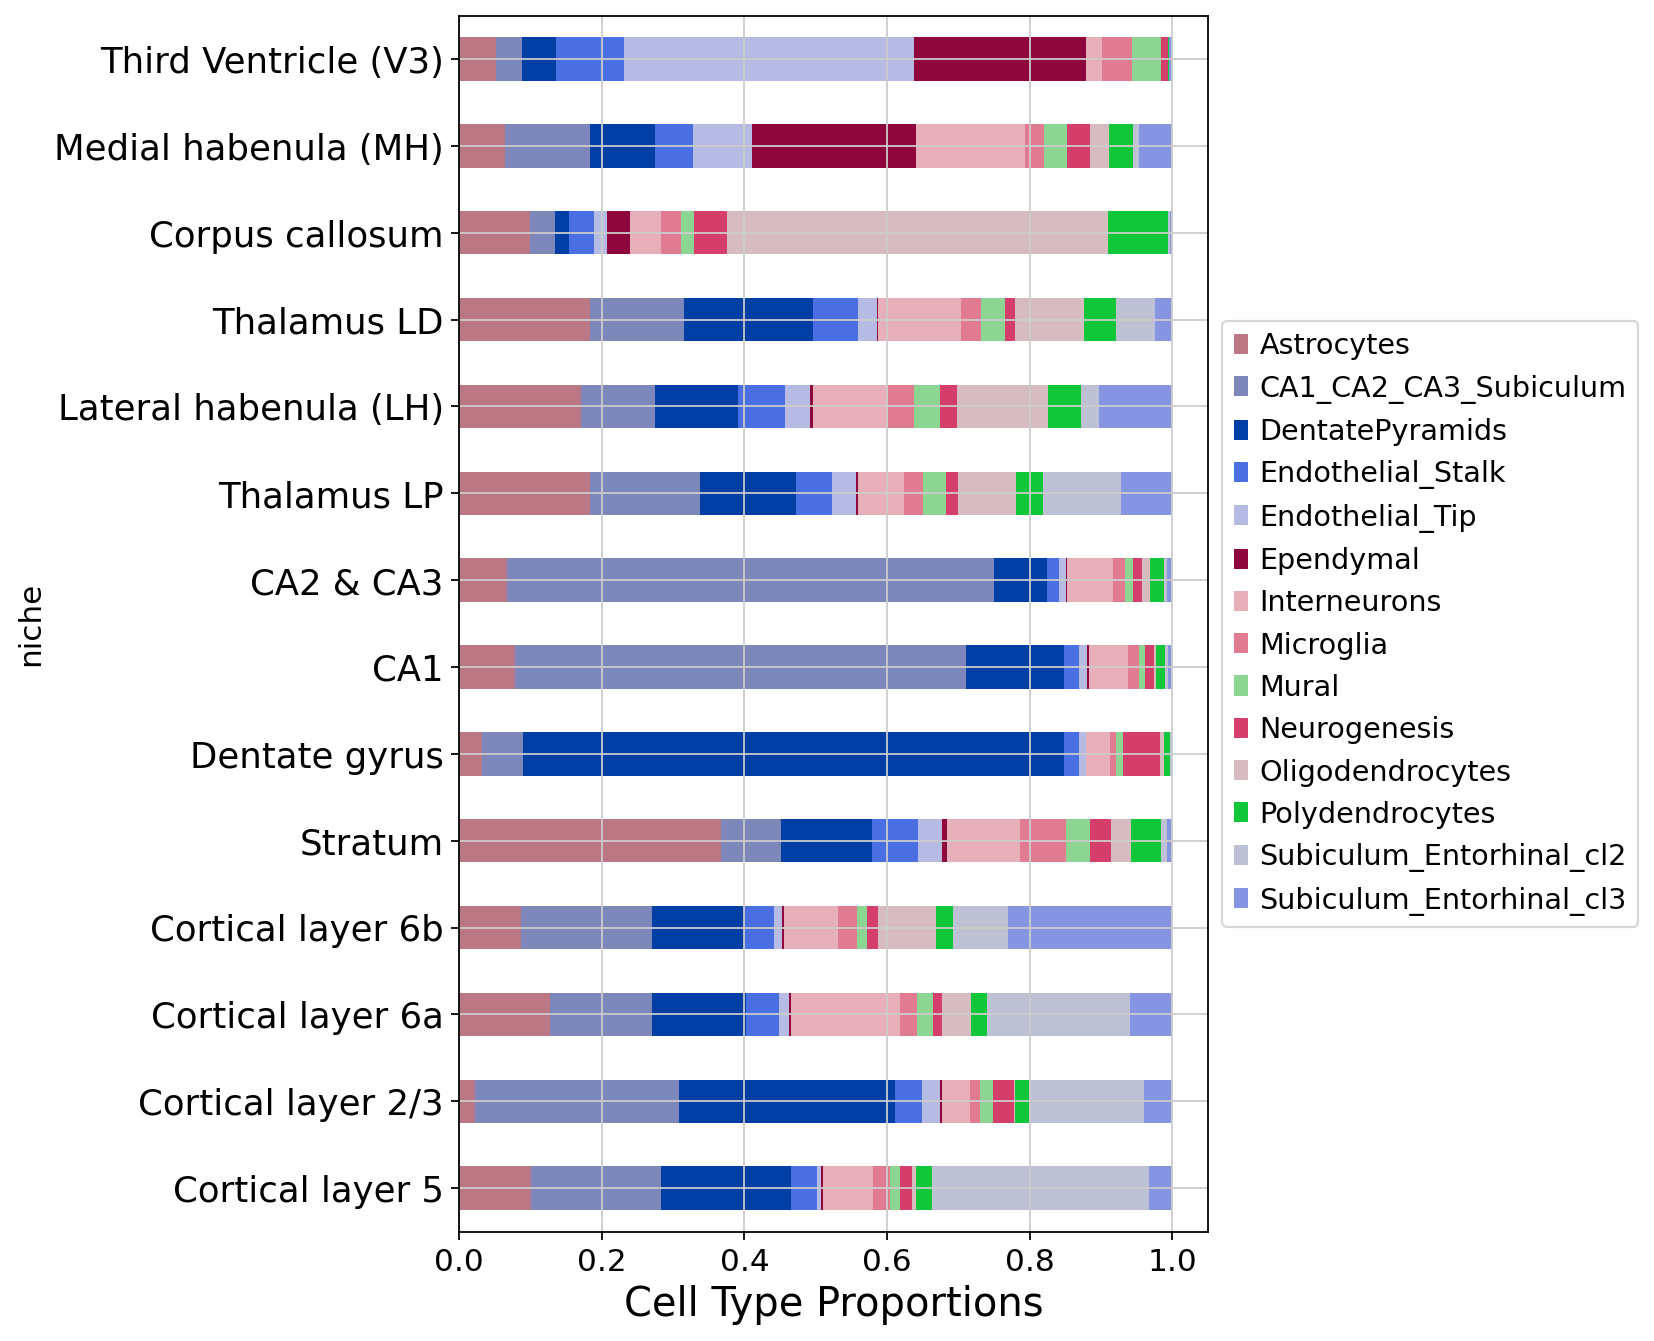

In [112]:
cell_type_colors = create_new_color_dict(
    adata=adata,
    color_palette="cell_type_30",
    cat_key="cell_type")

tmp = pd.crosstab(adata.obs["niche"], adata.obs["cell_type"], normalize='index')
tmp = tmp.reindex(adata.uns["dendrogram_niche"]["categories_ordered"][::])
ax = tmp.plot.barh(color=cell_type_colors, stacked=True, figsize=(6, 10)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.yticks(fontsize=16)
plt.xlabel("Cell Type Proportions", fontsize=16)
plt.savefig(f"{benchmarking_folder_path}/niche_cell_type_proportions.svg", bbox_inches='tight')

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["graphst"]
run_number = 2
leiden_resolutions = [0.93]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    niche_annotations = {
        "0": "Stratum",
        "1": "Lateral dorsal thalamus nucleus (LD)",
        "2": "Cortical Layers 5 & 2/3",
        "3": "Corpus callosum",
        "4": "Cortical Layer 6a",
        "5": "Cortical layer 6b",
        "6": "Lateral posterior thalamus nucleus (LP)",
        "7": "CA1",
        "8": "CA2 & CA3",
        "9": "Dentate gyrus",
        "10": "Third Ventricle (V3)",
        "11": "Medial habenula (MH)",
        "12": "Lateral habenula (LH)",
        "13": "Artifact"}

    adata.obs["niche"] = adata.obs["run2_leiden_0.93"].map(niche_annotations)

    niche_colors = {
     'Stratum': '#8BE0A4',
     'Lateral dorsal thalamus nucleus (LD)': '#F6CF71',
     'Cortical Layers 5 & 2/3': '#9EB9F3',
     'Cortical layer 6b': '#B497E7',
     'Lateral posterior thalamus nucleus (LP)': '#87C55F',
     'Corpus callosum': '#DAB6C4',
     'CA1': '#FE88B1',
     'Cortical layer 5': '#9EB9F3',
     'CA2 & CA3': '#DCB0F2',
     'Dentate gyrus': '#D3B484',
     'Medial habenula (MH)': '#F89C74',
     'Lateral habenula (LH)': '#C9DB74',
     'Cortical layer 2/3': '#276A8C',
     'Third Ventricle (V3)': '#B3B3B3',
     'Cortical Layer 6a': "#66C5CC",
     'Artifact': "#FF4D4D"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"niche",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=niche_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
sc.tl.dendrogram(adata=adata,
                 use_rep="graphst_latent_run2",
                 linkage_method="ward",
                 groupby="niche")

fig, (ax) = plt.subplots(1, 1, figsize=(2, 5))
sc.pl.dendrogram(
    adata=adata,
    groupby="niche",
    orientation="left",
    show=False,
    ax=ax)
plt.show()

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["sagenet"]
run_number = 2
leiden_resolutions = [0.0775]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#9EB9F3",
        "1": "#DAB6C4",
        "2": "#87C55F",
        "3": "#F6CF71",
        "4": "#9B4DCA",
        "5": "#276A8C",
        "6": "#8BE0A4",
        "7": "#DCB0F2",
        "8": "#FF9CDA",
        "9": "#F89C74",
        "10": "#FE88B1",
        "11": "#66C5CC",
        "12": "#D3B484",
        "13": "#B3B3B3"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["deeplinc"]
run_number = 2
leiden_resolutions = [1.05]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#66C5CC",
        "1": "#F6CF71",
        "2": "#87C55F",
        "3": "#D3B484",
        "4": "#DAB6C4",
        "5": "#FE88B1",
        "6": "#B497E7",
        "7": "#8BE0A4",
        "8": "#F89C74",
        "9": "#DCB0F2",
        "10": "#276A8C",
        "11": "#FF00FF",
        "12": "#B3B3B3",
        "13": "#DA70D6"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["scvi"]
run_number = 2
leiden_resolutions = [0.875]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#66C5CC",
        "1": "#8BE0A4",
        "2": "#DAB6C4",
        "3": "#F6CF71",
        "4": "#87C55F",
        "5": "#9D88A2",
        "6": "#F89C74",
        "7": "#BA55D3",
        "8": "#B3B3B3",
        "9": "#D3B484",
        "10": "#8A2BE2",
        "11": "#FE88B1",
        "12": "#DCB0F2",
        "13": "#276A8C"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [ ]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["expimap"]
run_number = 2
leiden_resolutions = [1.5]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#66C5CC",
        "1": "#F6CF71",
        "2": "#DAB6C4",
        "3": "#8BE0A4",
        "4": "#9D88A2",
        "5": "#FE88B1",
        "6": "#F89C74",
        "7": "#D3B484",
        "8": "#8A2BE2",
        "9": "#FF00FF",
        "10": "#48D1CC",
        "11": "#B3B3B3",
        "12": "#B497E7",
        "13": "#9B4DCA"}
    
    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")


Computing neighbor graph...


/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h


Computing UMAP embedding...

Computing Leiden clustering...


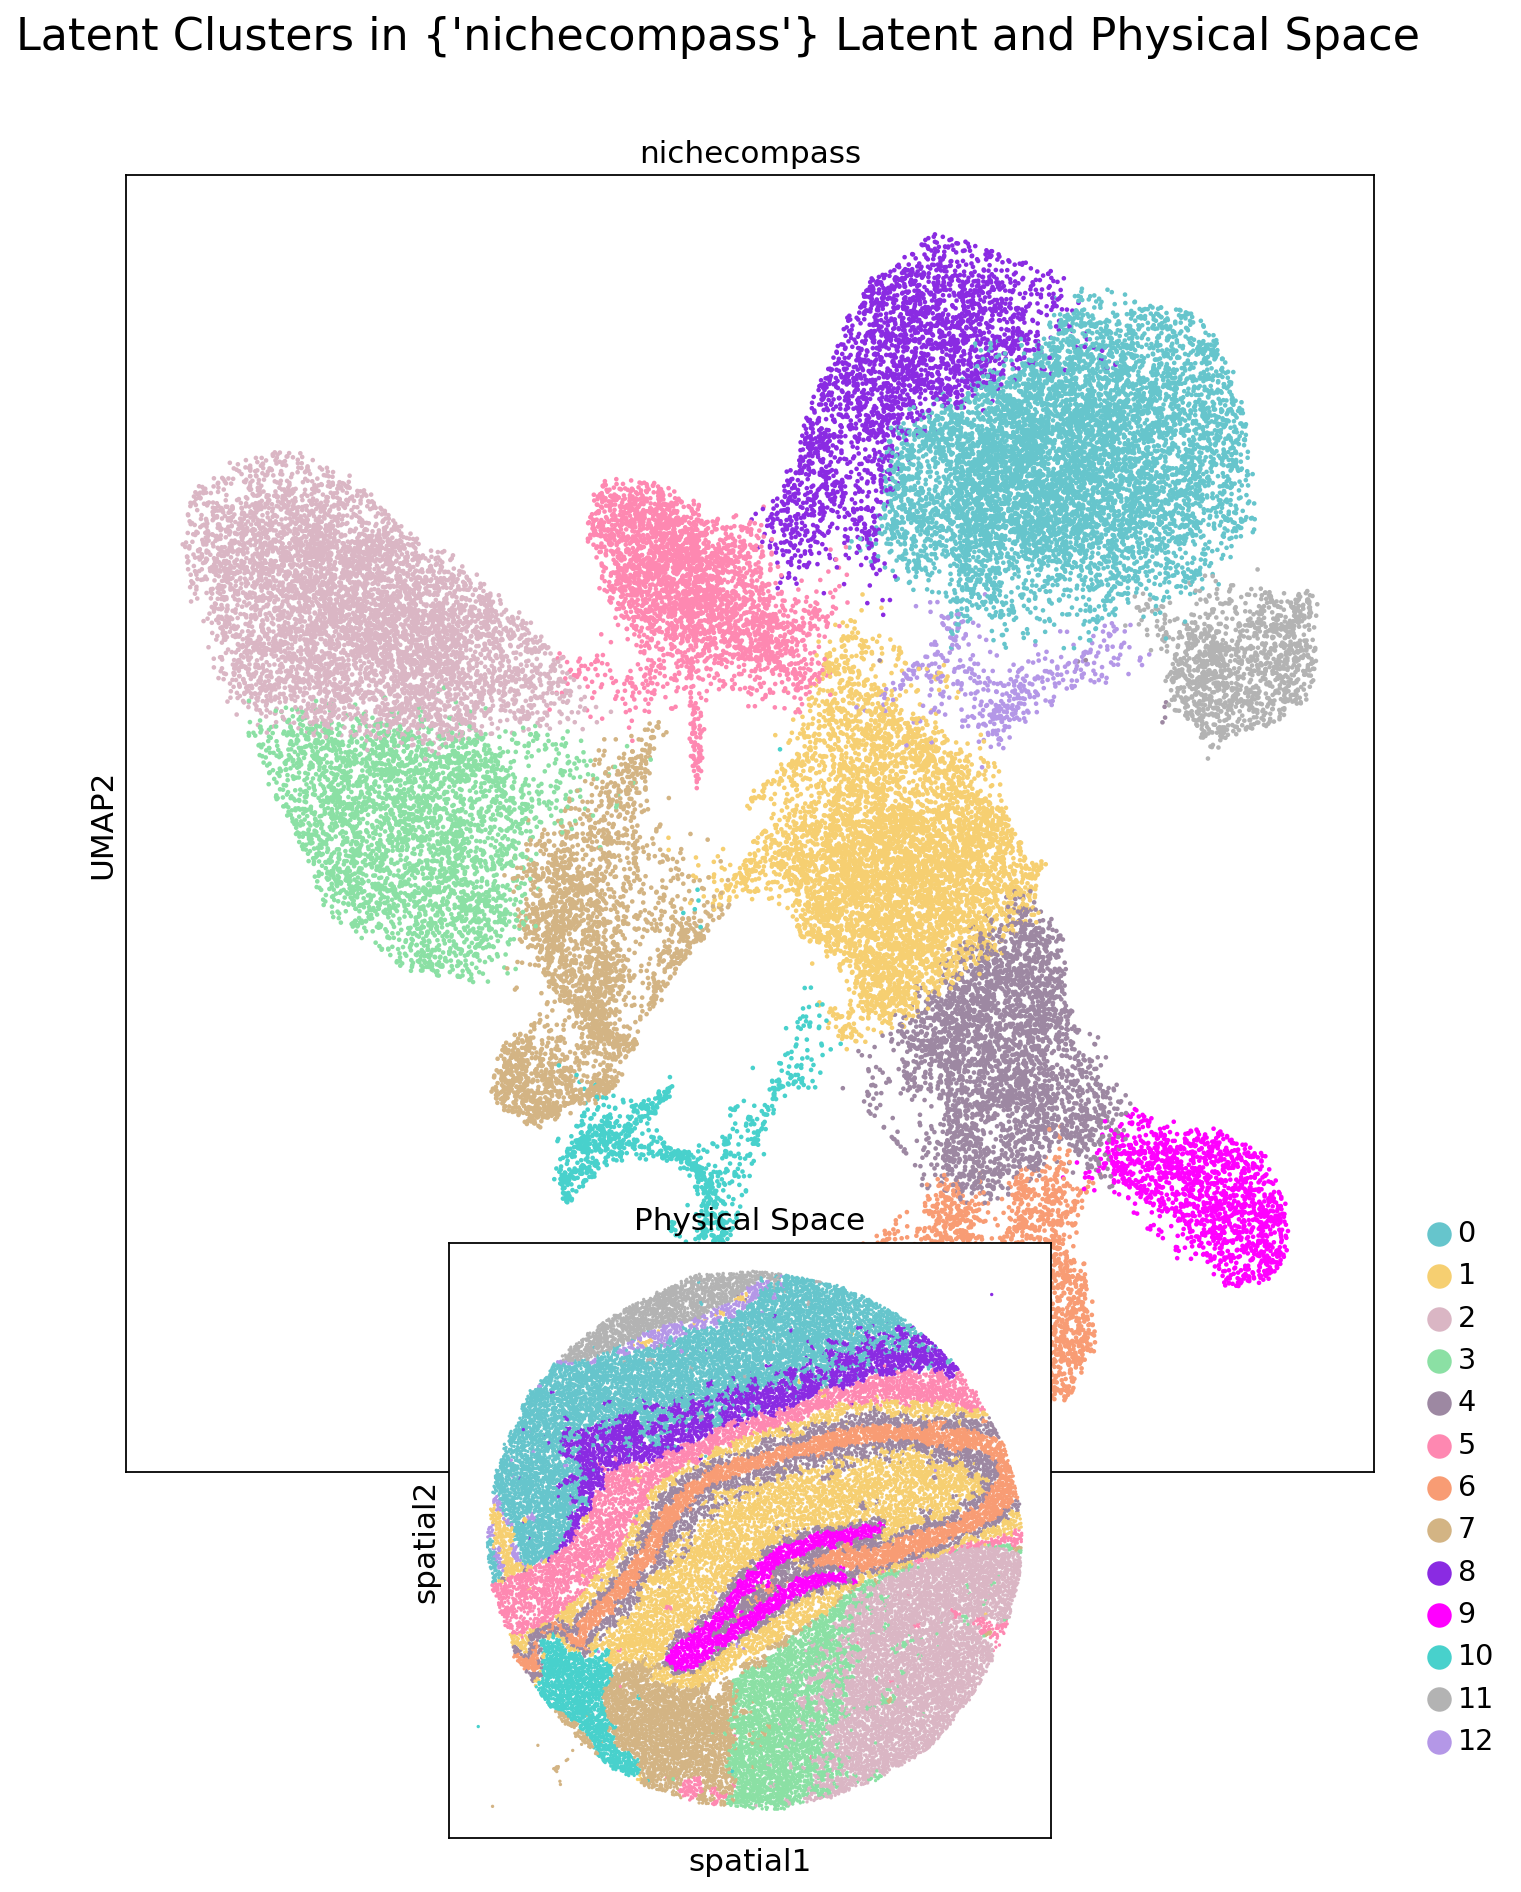

In [26]:
dataset = "slideseqv2_mouse_hippocampus"
models = ["nichecompass_gcnconv"]
run_number = 2
leiden_resolutions = [0.35]

for i, model in enumerate(models):
    adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
    model = model.replace("_gcnconv", "").replace("_gatv2conv", "")
    adata.obs["sample"] = "sample1"
    
    print("\nComputing neighbor graph...")
    # Use latent representation for UMAP generation
    sc.pp.neighbors(adata,
                    use_rep=f"{model}_latent_run{run_number}",
                    key_added=f"{model}_latent_run{run_number}")

    print("\nComputing UMAP embedding...")
    sc.tl.umap(adata,
               neighbors_key=f"{model}_latent_run{run_number}")
        
    print("\nComputing Leiden clustering...")
    sc.tl.leiden(adata=adata,
                 resolution=leiden_resolutions[i],
                 key_added=f"run{run_number}_leiden_{leiden_resolutions[i]}",
                 neighbors_key=f"{model}_latent_run{run_number}")
    
    latent_cluster_colors = {
        "0": "#66C5CC",
        "1": "#F6CF71",
        "2": "#DAB6C4",
        "3": "#8BE0A4",
        "4": "#9D88A2",
        "5": "#FE88B1",
        "6": "#F89C74",
        "7": "#D3B484",
        "8": "#8A2BE2",
        "9": "#FF00FF",
        "10": "#48D1CC",
        "11": "#B3B3B3",
        "12": "#B497E7",
        "13": "#9B4DCA"}

    plot_category_in_latent_and_physical_space(
            adata=adata,
            plot_label="Latent Clusters",
            model_label={model},
            cat_key=f"run{run_number}_leiden_{leiden_resolutions[i]}",
            groups=None,
            sample_key="sample",
            samples=["sample1"],
            cat_colors=latent_cluster_colors,
            size=(720000 / len(adata)),
            spot_size=30,
            save_fig=True,
            file_path=f"{benchmarking_folder_path}/latent_clusters_{model}.svg")

In [101]:
datasets = ["slideseqv2_mouse_hippocampus",
            "slideseqv2_mouse_hippocampus_subsample_50pct",
            "slideseqv2_mouse_hippocampus_subsample_25pct",
            "slideseqv2_mouse_hippocampus_subsample_10pct",
            "slideseqv2_mouse_hippocampus_subsample_5pct",
            "slideseqv2_mouse_hippocampus_subsample_1pct"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "deeplinc",
          "graphst",
          "sagenet",
          #"scvi",
          #"expimap"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[0:2]], weights=metric_col_weights_single_sample[0:2], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[2:4]], weights=metric_col_weights_single_sample[2:4], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[4:6]], weights=metric_col_weights_single_sample[4:6], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_50pct_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_25pct_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_10pct_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_5pct_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_1pct_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/slideseqv2_mouse_hippocampus_subsample_1pct_sagenet_metrics.csv. Continuing...


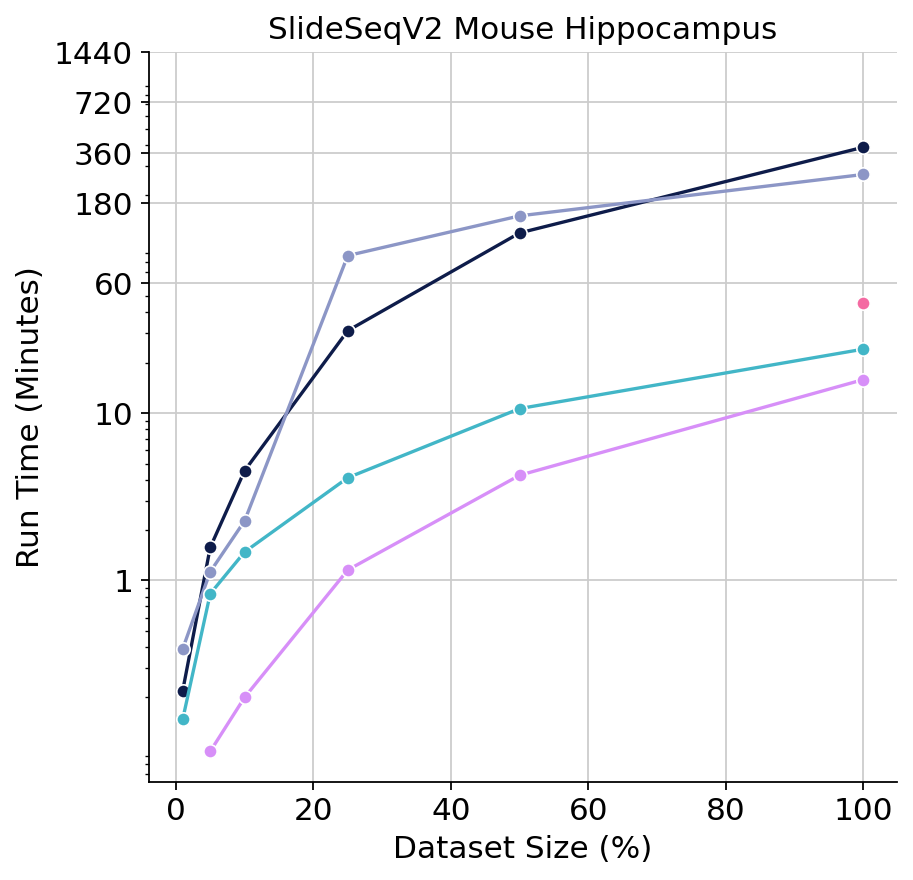

In [102]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "slideseqv2_mouse_hippocampus":
        return 100
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_50pct":    
        return 50
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_25pct":    
        return 25
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_10pct":    
        return 10
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_5pct":    
        return 5
    elif row["dataset"] == "slideseqv2_mouse_hippocampus_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("SlideSeqV2 Mouse Hippocampus")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, custom_y_ticks)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_slideseqv2_mouse_hippocampus.svg")
plt.show()

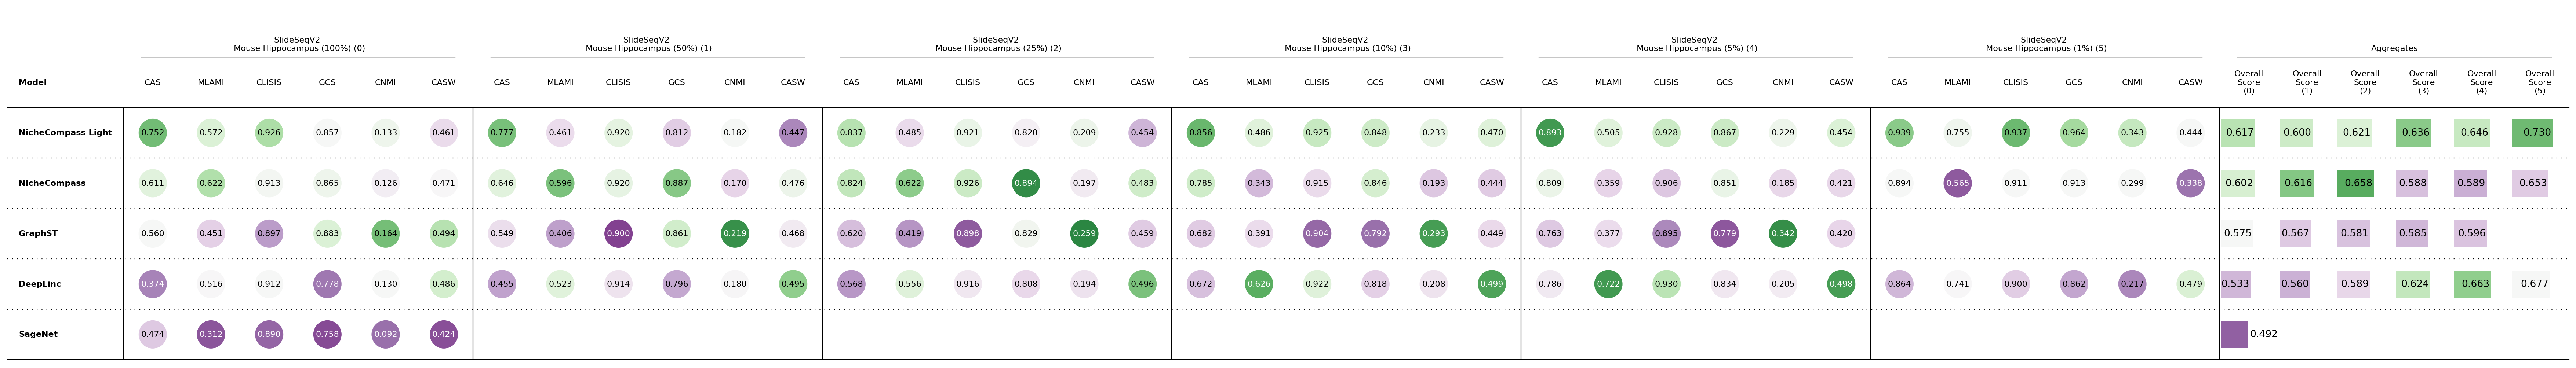

In [103]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.2,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=1.1, # 0.8,
    plot_width=56, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_slideseqv2_mouse_hippocampus.svg")

#### 2.1.2 seqFISH Mouse Organogenesis

In [98]:
datasets = ["seqfish_mouse_organogenesis_embryo2",
            "seqfish_mouse_organogenesis_subsample_50pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_25pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_10pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_5pct_embryo2",
            "seqfish_mouse_organogenesis_subsample_1pct_embryo2"]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "deeplinc",
          "graphst",
          "sagenet",
          #"scvi",
          #"expimap"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
        #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
        #training_durations = []
        #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
        #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
        #benchmark_df["run_time"] = training_durations
        #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
        #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
        benchmark_df["model"] = model
        benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[0:2]], weights=metric_col_weights_single_sample[0:2], axis=1)
        benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[2:4]], weights=metric_col_weights_single_sample[2:4], axis=1)
        benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[4:6]], weights=metric_col_weights_single_sample[4:6], axis=1)
        benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
        summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

print(summary_df["model"].value_counts())
print(summary_df[summary_df.isna().any(axis=1)])

NicheCompass          48
NicheCompass Light    48
DeepLinc              48
GraphST               48
SageNet               48
Name: model, dtype: int64
Empty DataFrame
Columns: [dataset, run_number, run_time, gcs, mlami, cas, clisis, nasw, cnmi, cari, casw, clisi, model, Local Spatial Conservation Score, Global Spatial Conservation Score, Cell Type Conservation Score, Overall Score]
Index: []


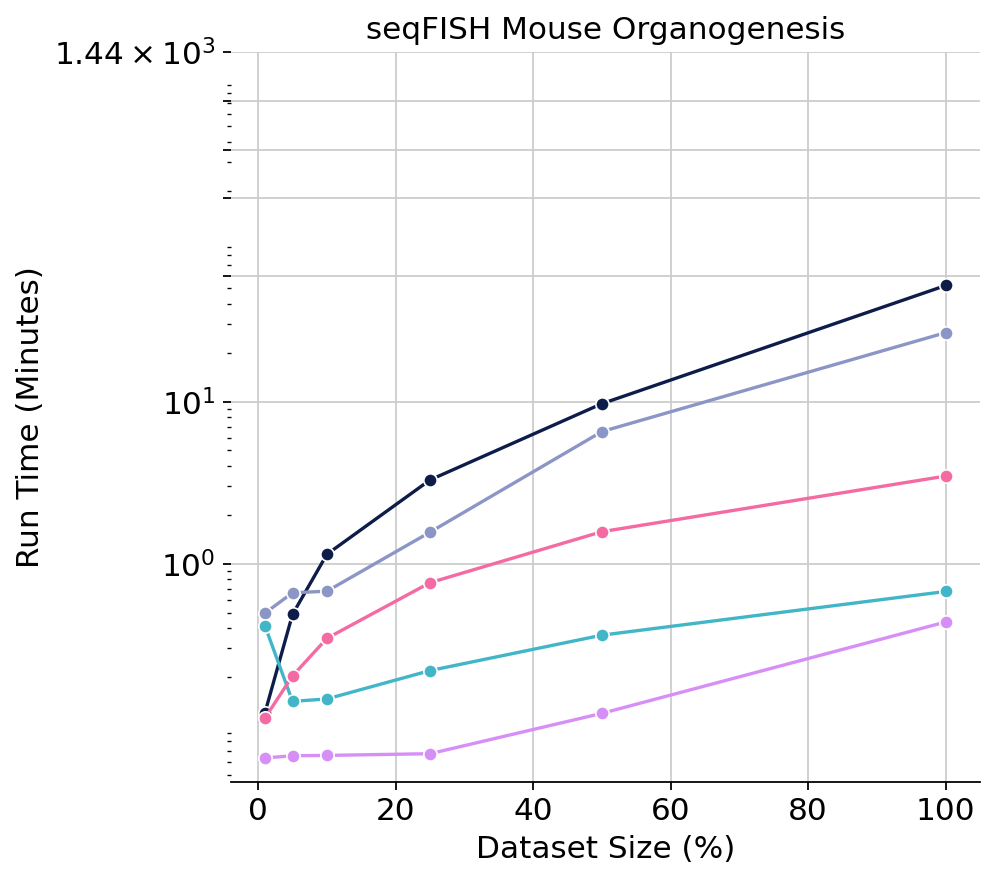

In [99]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "seqfish_mouse_organogenesis_embryo2":
        return 100
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_50pct_embryo2":    
        return 50
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_25pct_embryo2":    
        return 25
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_10pct_embryo2":    
        return 10
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_5pct_embryo2":    
        return 5
    elif row["dataset"] == "seqfish_mouse_organogenesis_subsample_1pct_embryo2":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title("seqFISH Mouse Organogenesis")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, None)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_seqfish_mouse_organogenesis.svg")
plt.show()

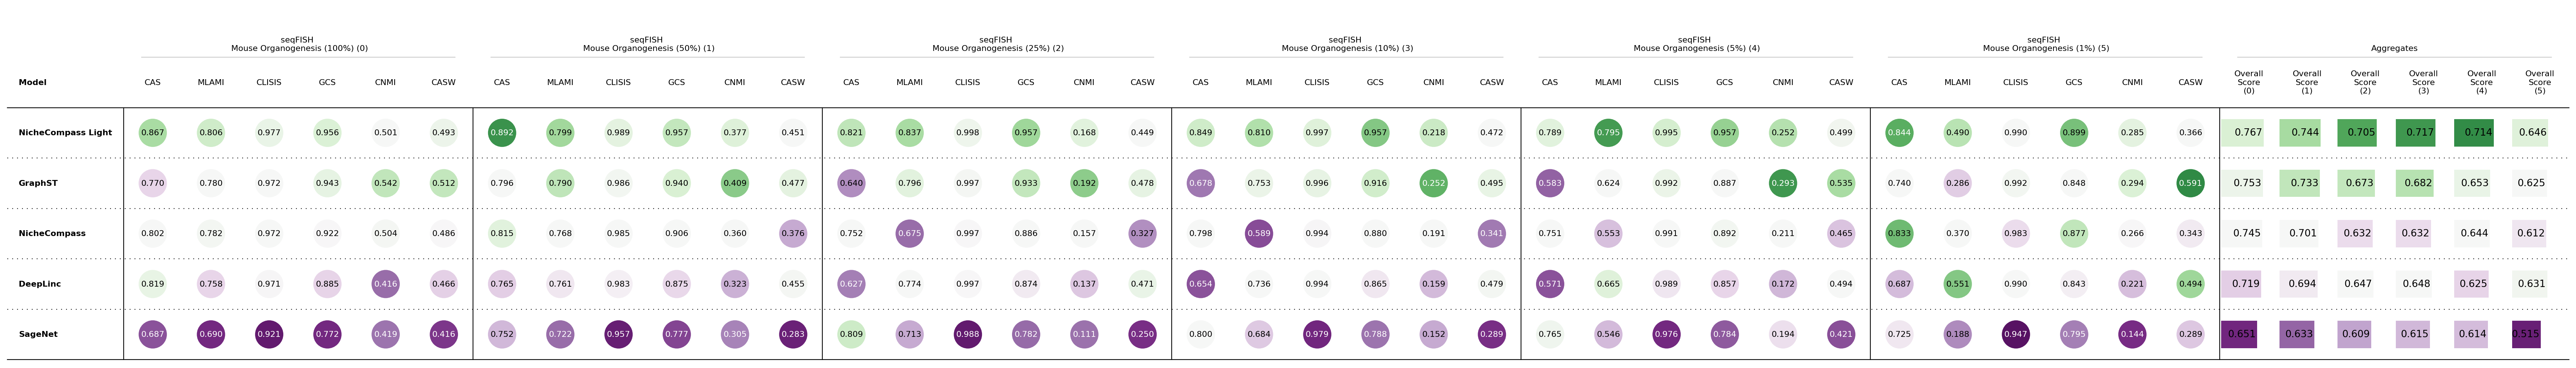

In [100]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.2,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=1.1, # 0.8,
    plot_width=56, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_seqfish_mouse_organogenesis.svg")

#### 2.1.3 nanoString CosMx SMI Human Non-Small-Cell Lung Cancer (NSCLC)

In [95]:
datasets = ["nanostring_cosmx_human_nsclc_batch5",
            "nanostring_cosmx_human_nsclc_subsample_50pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_25pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_10pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_5pct_batch5",
            "nanostring_cosmx_human_nsclc_subsample_1pct_batch5"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "deeplinc",
          "graphst",
          "sagenet",
          #"scvi",
          #"expimap"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[:2]], weights=metric_col_weights_single_sample[0:2], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[2:4]], weights=metric_col_weights_single_sample[2:4], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[4:6]], weights=metric_col_weights_single_sample[4:6], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

Did not find file ../../artifacts/single_sample_method_benchmarking/nanostring_cosmx_human_nsclc_batch5_deeplinc_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/nanostring_cosmx_human_nsclc_batch5_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/nanostring_cosmx_human_nsclc_batch5_sagenet_metrics.csv. Continuing...


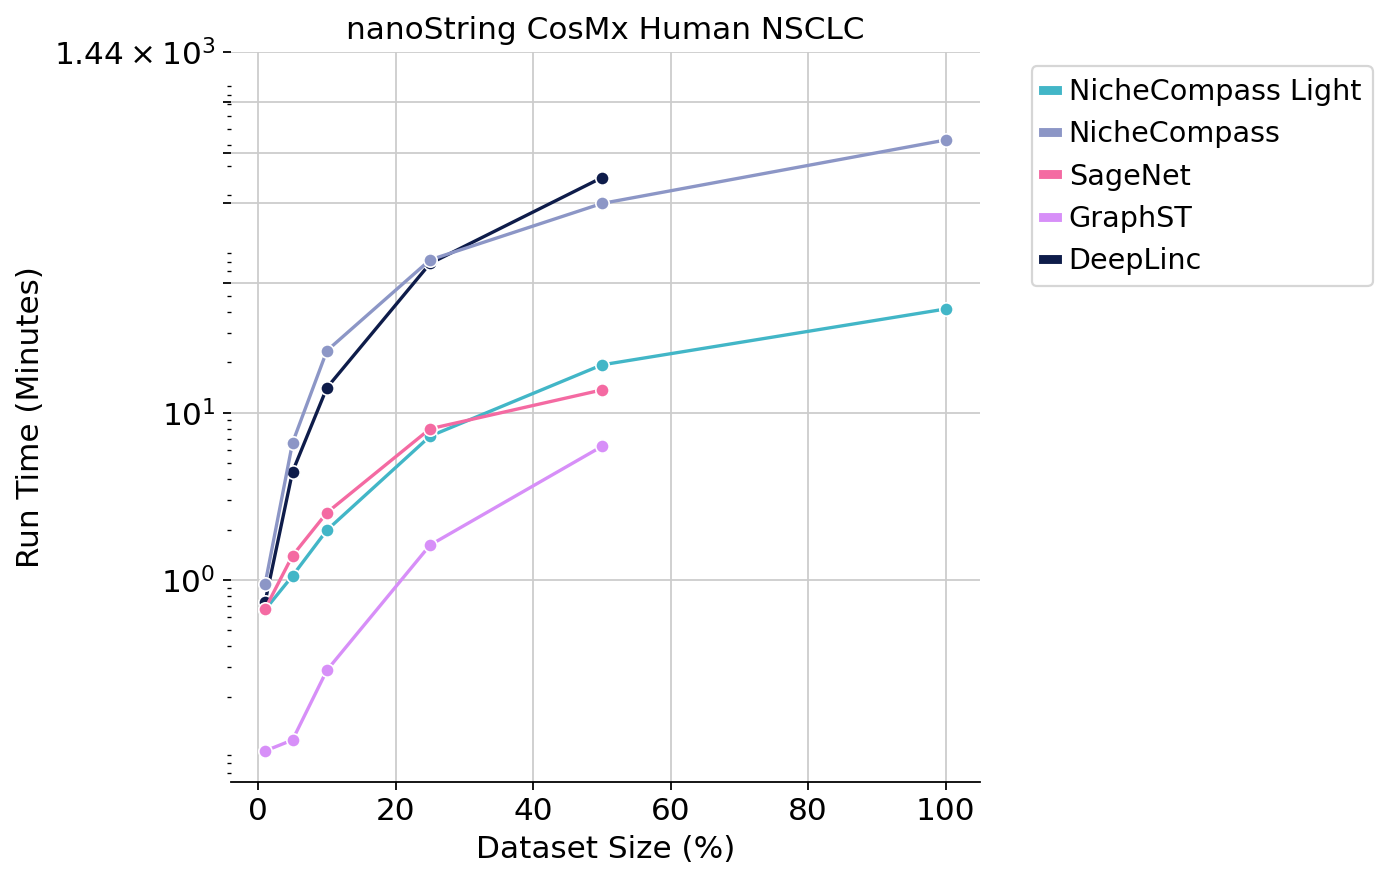

In [96]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "nanostring_cosmx_human_nsclc_batch5":
        return 100
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_50pct_batch5":    
        return 50
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_25pct_batch5":    
        return 25
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_10pct_batch5":    
        return 10
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_5pct_batch5":    
        return 5
    elif row["dataset"] == "nanostring_cosmx_human_nsclc_subsample_1pct_batch5":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title("nanoString CosMx Human NSCLC")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, None)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
lgd = plt.legend(ordered_handles, ordered_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()
#ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_nanostring_cosmx_human_nsclc.svg", bbox_inches="tight", bbox_extra_artists=[lgd])
plt.show()

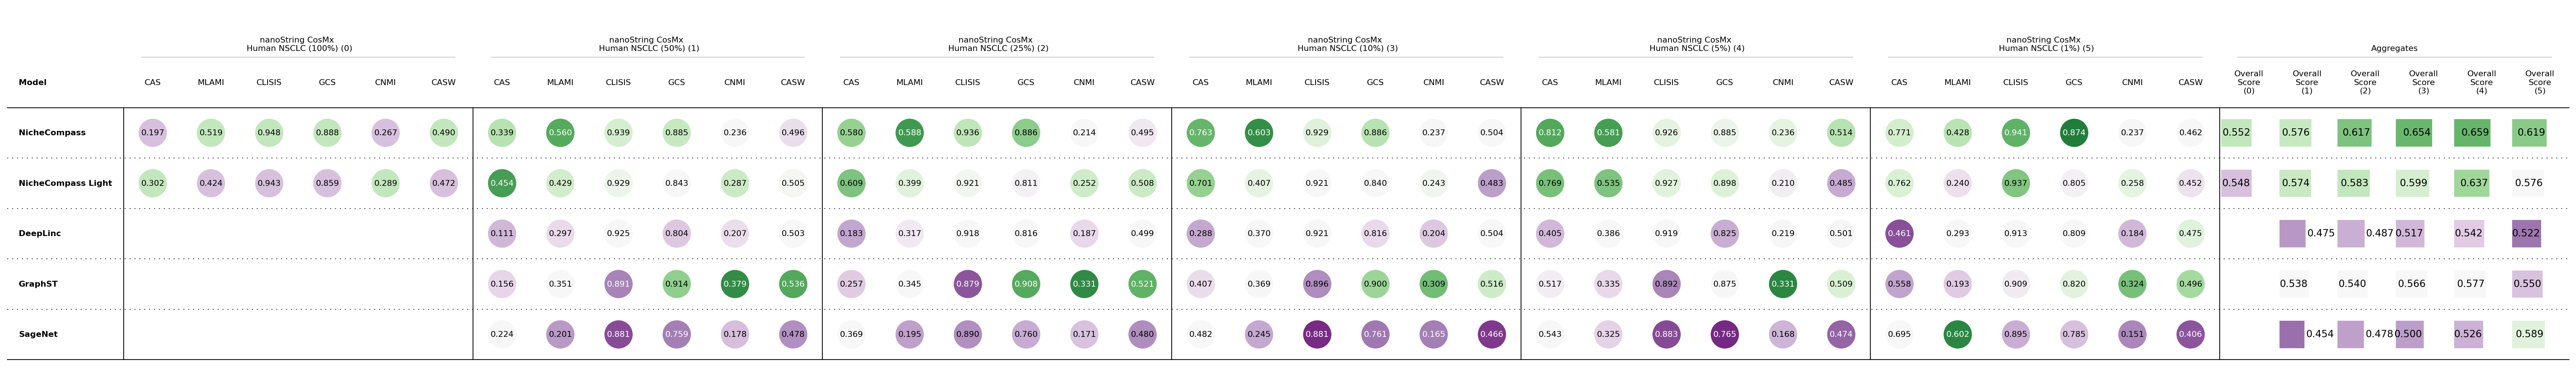

In [97]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.2,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample],
    metric_col_width=1.1, # 0.8,
    plot_width=56, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_nanostring_cosmx_human_nsclc.svg")

#### 2.1.4 Vizgen MERFISH Mouse Liver

In [87]:
datasets = ["vizgen_merfish_mouse_liver",
            "vizgen_merfish_mouse_liver_subsample_50pct",
            "vizgen_merfish_mouse_liver_subsample_25pct",
            "vizgen_merfish_mouse_liver_subsample_10pct",
            "vizgen_merfish_mouse_liver_subsample_5pct",
            "vizgen_merfish_mouse_liver_subsample_1pct"]
models = ["nichecompass_gcnconv",
          "nichecompass_gatv2conv",
          "deeplinc",
          "graphst",
          "sagenet",
          #"scvi",
          #"expimap"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[0:2]], weights=metric_col_weights_single_sample[0:2], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[2:4]], weights=metric_col_weights_single_sample[2:4], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[4:6]], weights=metric_col_weights_single_sample[4:6], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_deeplinc_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_subsample_50pct_deeplinc_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_subsample_50pct_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_subsample_50pct_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_subsample_25pct_deeplinc_metrics.csv. Continuing...
Did not find file ../..

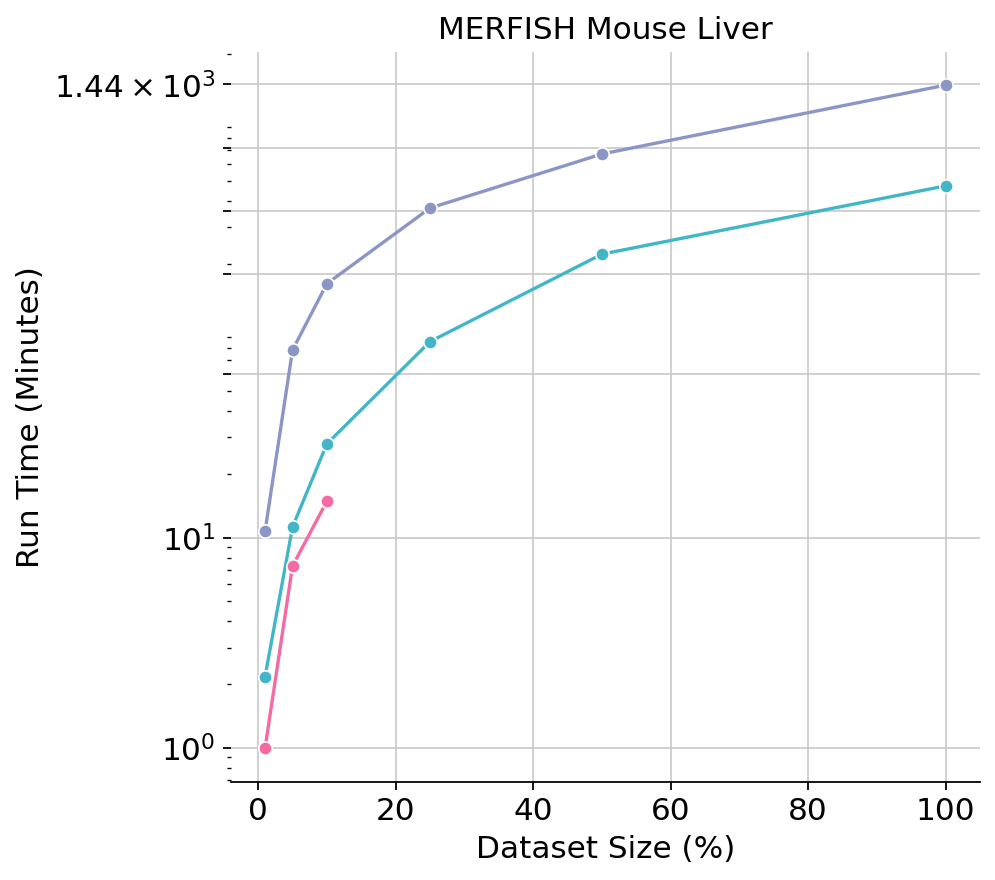

In [88]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

run_time_mean_df = summary_df.groupby(["dataset", "model"])[["run_time"]].mean().reset_index()
run_time_mean_df["run_time"] = run_time_mean_df["run_time"] / 60

def create_dataset_share_col(row):
    if row["dataset"] == "vizgen_merfish_mouse_liver":
        return 100
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_50pct":    
        return 50
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_25pct":    
        return 25
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_10pct":    
        return 10
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_5pct":    
        return 5
    elif row["dataset"] == "vizgen_merfish_mouse_liver_subsample_1pct":    
        return 1
    
run_time_mean_df["dataset_share"] = run_time_mean_df.apply(lambda row: create_dataset_share_col(row), axis=1)
    
ax = sns.lineplot(data=run_time_mean_df,
                  x="dataset_share",
                  y="run_time",
                  hue="model",
                  marker='o',
                  palette=model_palette)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title("MERFISH Mouse Liver")
plt.ylabel("Run Time (Minutes)")
plt.xlabel("Dataset Size (%)")
custom_y_ticks = [1, 10, 60, 180, 360, 720, 1440]  # Adjust the tick positions as needed
plt.yscale("log")
plt.yticks(custom_y_ticks, None)
legend = plt.gca().get_legend()
for handle in legend.legendHandles:
    handle.set_linewidth(4.0)  # Adjust the size as needed
handles, labels = legend.legendHandles, [text.get_text() for text in legend.get_texts()]
order = [3, 2, 4, 1, 0]
ordered_handles = [handles[i] for i in order]
ordered_labels = [labels[i] for i in order]
plt.legend(ordered_handles, ordered_labels)
ax = plt.gca()
ax.legend().set_visible(False)
plt.savefig(benchmarking_folder_path + "/benchmarking_runtimes_vizgen_merfish_mouse_liver.svg")
plt.show()

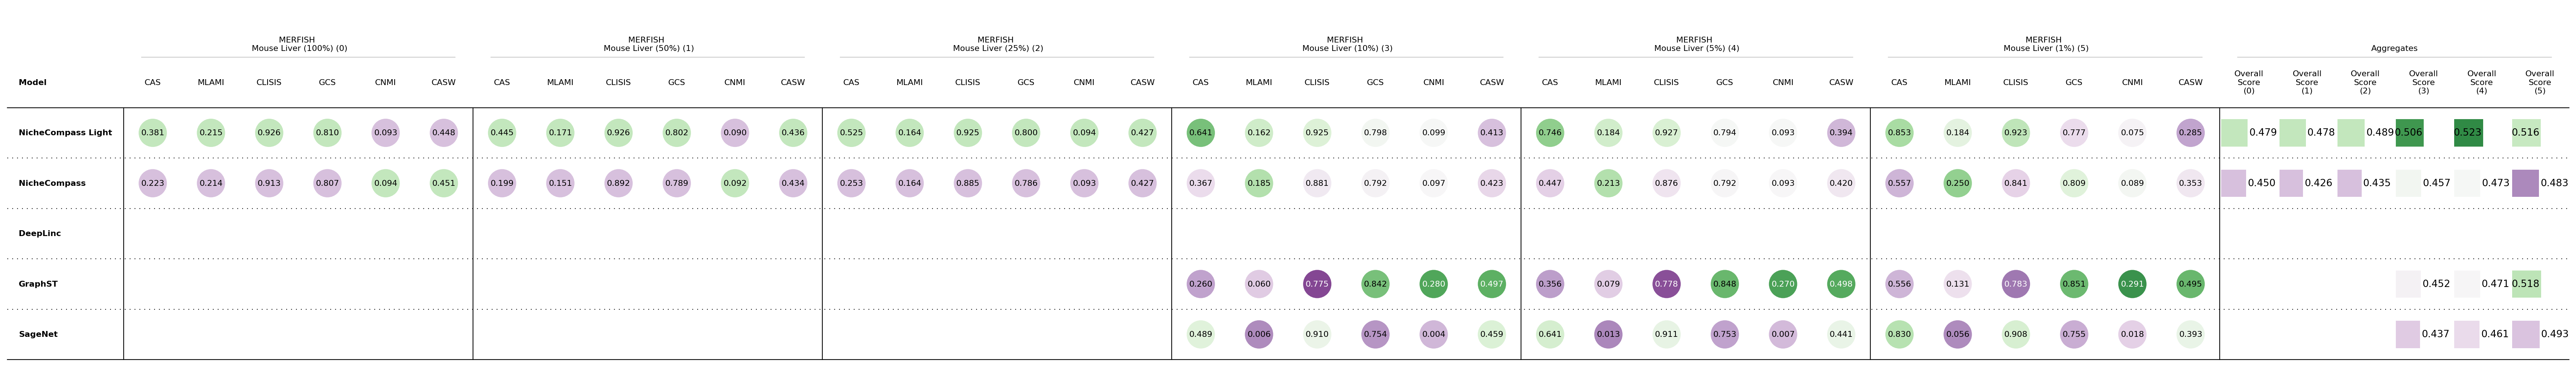

In [94]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.2,
    group_col="dataset",
    metric_cols=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
    metric_col_weights=metric_col_weights_single_sample, # metric_col_weights_single_sample, category_col_weights_single_sample
    metric_col_titles=[col.replace(" ", "\n") for col in metric_col_titles_single_sample], # category_col_titles_single_sample
    metric_col_width=1.1, # 0.8,
    plot_width=56, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_vizgen_merfish_mouse_liver.svg")

#### 2.1.5 All Datasets

In [94]:
fig_width_8_ticks = 7.5
fig_width_6_ticks = 6.6
fig_width_5_ticks = 6.2
fig_width_2_ticks = 5.0
fig_width_3_ticks = 5.4
fig_height = 5
fontsize = 14

In [95]:
datasets = ["slideseqv2_mouse_hippocampus",
            "seqfish_mouse_organogenesis_embryo2",
            "vizgen_merfish_mouse_liver",
            "nanostring_cosmx_human_nsclc_batch5",]
models = ["nichecompass_gatv2conv",
          "nichecompass_gcnconv",
          "deeplinc",
          "graphst",
          "sagenet",
          #"scvi",
          #"expimap"
         ]

summary_df = pd.DataFrame()
for dataset in datasets:
    for model in models:
        try:
            benchmark_df = pd.read_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv")
            #adata = sc.read_h5ad(f"../../artifacts/single_sample_method_benchmarking/{dataset}_{model}.h5ad")
            #training_durations = []
            #for run_number in [1, 2, 3, 4, 5, 6, 7, 8]:
            #    training_durations.append(adata.uns[f"{model.split('_')[0]}_model_training_duration_run{run_number}"])
            #benchmark_df["run_time"] = training_durations
            #benchmark_df = benchmark_df[["dataset", "run_number", "run_time", "gcs", "mlami", "cas", "clisis", "nasw", "cnmi", "cari", "casw", "clisi"]]
            #benchmark_df.to_csv(f"{benchmarking_folder_path}/{dataset}_{model}_metrics.csv", index=False)
            benchmark_df["model"] = model
            benchmark_df[category_cols_single_sample[0]] = np.average(benchmark_df[metric_cols_single_sample[0:2]], weights=metric_col_weights_single_sample[0:2], axis=1)
            benchmark_df[category_cols_single_sample[1]] = np.average(benchmark_df[metric_cols_single_sample[2:4]], weights=metric_col_weights_single_sample[2:4], axis=1)
            benchmark_df[category_cols_single_sample[2]] = np.average(benchmark_df[metric_cols_single_sample[4:6]], weights=metric_col_weights_single_sample[4:6], axis=1)
            benchmark_df["Overall Score"] = np.average(benchmark_df[category_cols_single_sample[:3]], weights=category_col_weights_single_sample[:3] ,axis=1)
            summary_df = pd.concat([summary_df, benchmark_df], ignore_index=True)
        except FileNotFoundError:
            print(f"Did not find file {benchmarking_folder_path}/{dataset}_{model}_metrics.csv. Continuing...")
            missing_run_data = {
                "dataset": [dataset] * 8,
                "model": [model] * 8,
                "run_number": [1, 2, 3, 4, 5, 6, 7, 8],
                "run_time": [np.nan] * 8
            }
            missing_run_df = pd.DataFrame(missing_run_data)
            summary_df = summary_df.append(missing_run_df, ignore_index=True)
            continue
 
# Reformat for plot
summary_df.replace({"nichecompass_gatv2conv": "NicheCompass",
                    "nichecompass_gcnconv": "NicheCompass Light",
                    "deeplinc": "DeepLinc",
                    "expimap": "expiMap",
                    "graphst": "GraphST",
                    "sagenet": "SageNet",
                    "scvi": "scVI"}, inplace=True)

# Plot over all loss weights combinations
# Prepare metrics table plot
group_cols = ["dataset", "model"]
aggregate_df = summary_df.groupby(group_cols).mean("Overall Score").sort_values("Overall Score", ascending=False)[
    metric_cols_single_sample].reset_index()

unrolled_df = pd.melt(aggregate_df, 
   id_vars=group_cols,
   value_vars=metric_cols_single_sample, # metric_cols_single_sample, category_cols_single_sample
   var_name="score_type", 
   value_name="score")

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model"] in ["NicheCompass GCN", "NicheCompass GATv2", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
unrolled_df["spatially_aware"] = unrolled_df.apply(lambda row: is_spatially_aware_model(row), axis=1)
unrolled_df = unrolled_df[["dataset", "spatially_aware", "model", "score_type", "score"]]

# Order datasets
unrolled_df["dataset"] = pd.Categorical(unrolled_df["dataset"], categories=datasets, ordered=True)
unrolled_df = unrolled_df.sort_values(by="dataset")

#print(summary_df["model"].value_counts())
#print(summary_df[summary_df.isna().any(axis=1)])

summary_df["model"] = summary_df["model"].replace("NicheCompass GCN", "NicheCompass Light")
summary_df["model"] = summary_df["model"].replace("NicheCompass GATv2", "NicheCompass")

summary_df["dataset"] = summary_df["dataset"].replace(
    {"slideseqv2_mouse_hippocampus": "SlideSeqV2 Mouse Hippocampus",
     "seqfish_mouse_organogenesis_embryo2": "seqFISH Mouse Organogenesis",
     "nanostring_cosmx_human_nsclc_batch5": "nanoString CosMx Human NSCLC",
     "vizgen_merfish_mouse_liver": "MERFISH Mouse Liver"})

Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_deeplinc_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/vizgen_merfish_mouse_liver_sagenet_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/nanostring_cosmx_human_nsclc_batch5_deeplinc_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/nanostring_cosmx_human_nsclc_batch5_graphst_metrics.csv. Continuing...
Did not find file ../../artifacts/single_sample_method_benchmarking/nanostring_cosmx_human_nsclc_batch5_sagenet_metrics.csv. Continuing...


/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/min

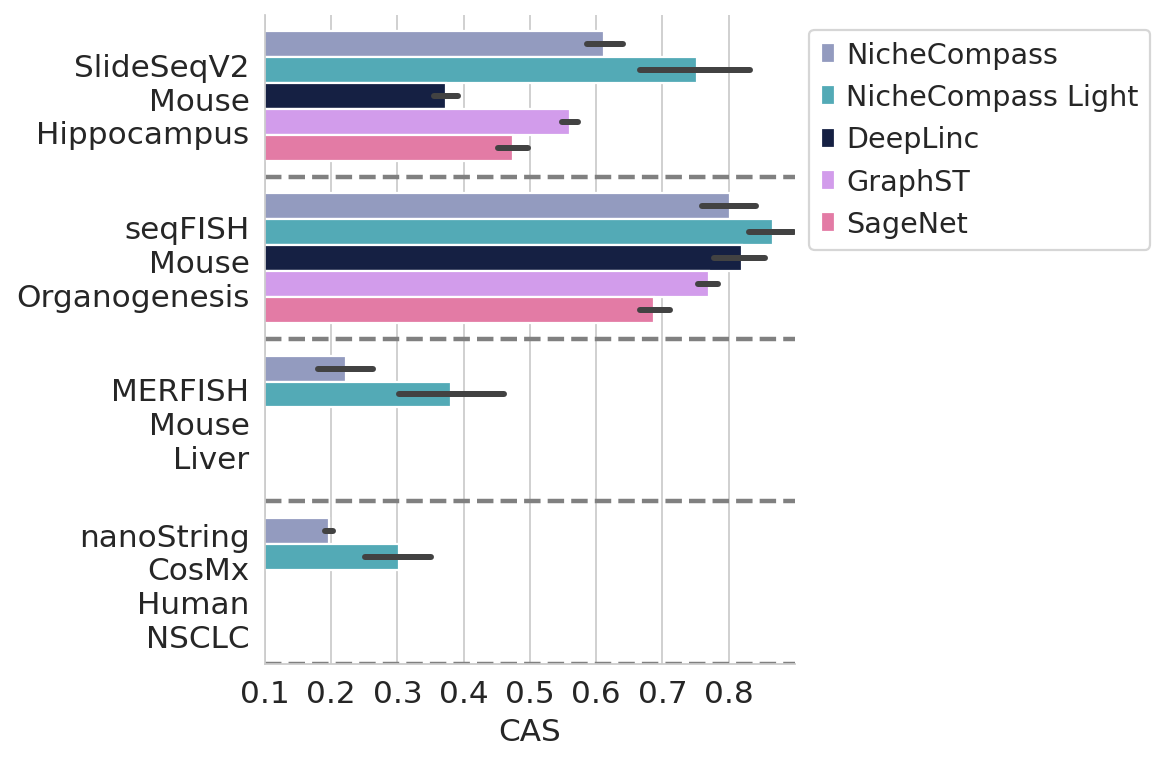

In [60]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_8_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="cas",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("CAS", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=fontsize)
plt.xlim(0.1, 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_cas.svg")
plt.show()

In [61]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["cas"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

cas    1.090383
dtype: float64

In [62]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["cas"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

cas    1.042427
dtype: float64

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/min

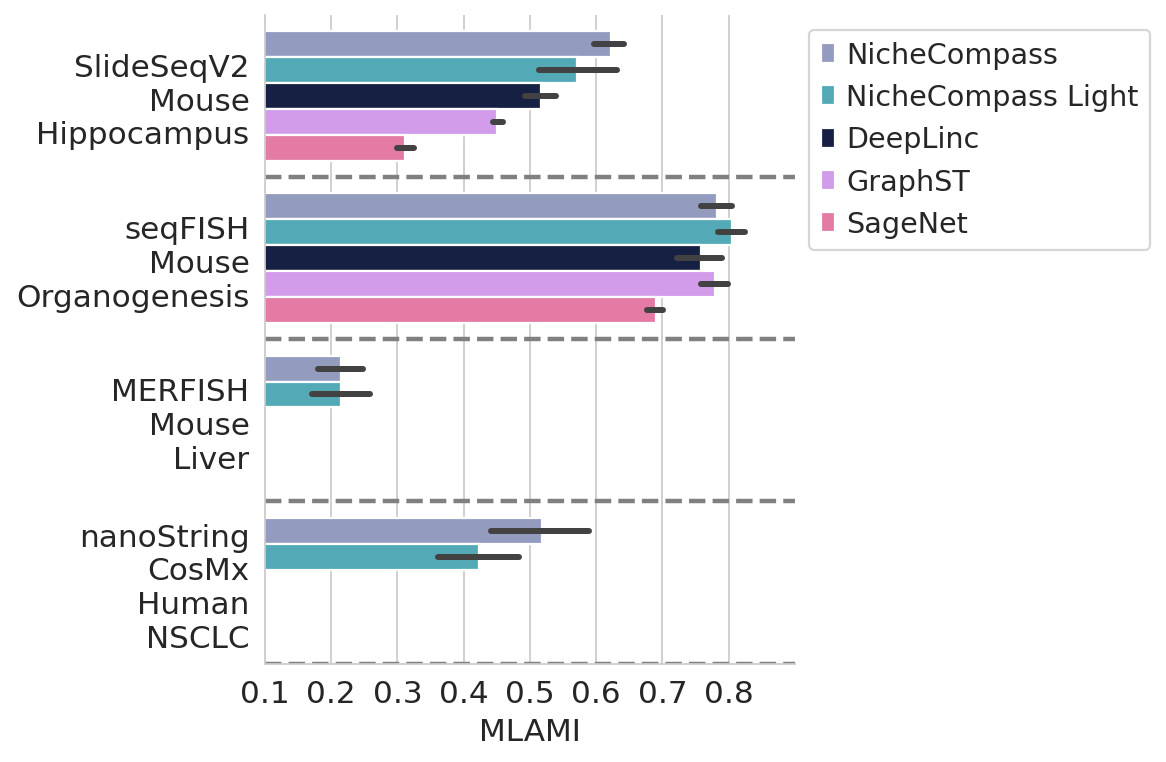

In [63]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_8_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="mlami",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("MLAMI", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=fontsize)
plt.xlim(0.1, 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_mlami.svg")
plt.show()

In [64]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["mlami"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

mlami    1.38113
dtype: float64

In [65]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["mlami"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

mlami    1.00372
dtype: float64

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/min

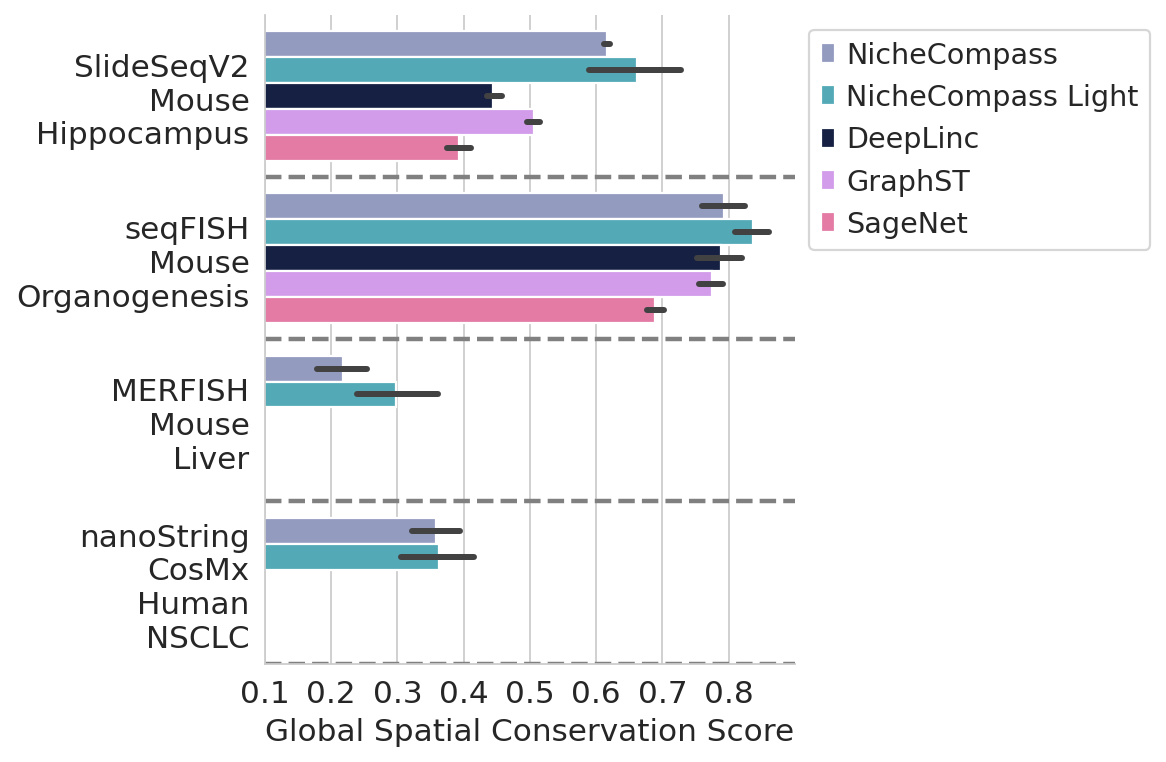

In [66]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_8_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="Global Spatial Conservation Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Global Spatial Conservation Score", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=fontsize)
plt.xlim(0.1, 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_global_spatial_conservation_score.svg")
plt.show()

In [67]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["Global Spatial Conservation Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

Global Spatial Conservation Score    1.219963
dtype: float64

In [68]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Global Spatial Conservation Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

Global Spatial Conservation Score    1.022952
dtype: float64

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/min

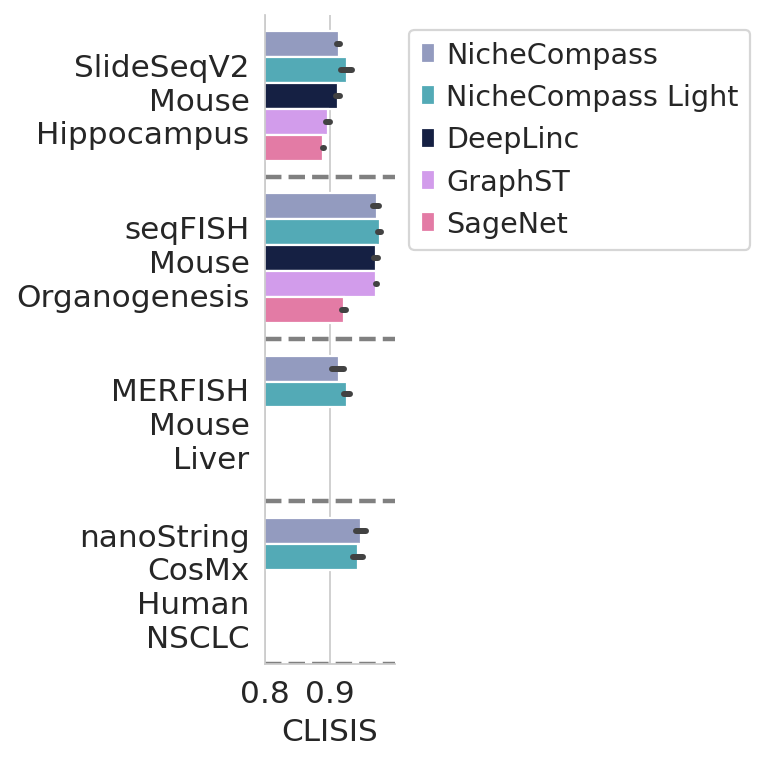

In [69]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_2_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="clisis",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("CLISIS", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0.8, 0.9], fontsize=fontsize)
plt.xlim(0.8, 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_clisis.svg")
plt.show()

In [70]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["clisis"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

clisis    1.018009
dtype: float64

In [71]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["clisis"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

clisis    1.000143
dtype: float64

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/min

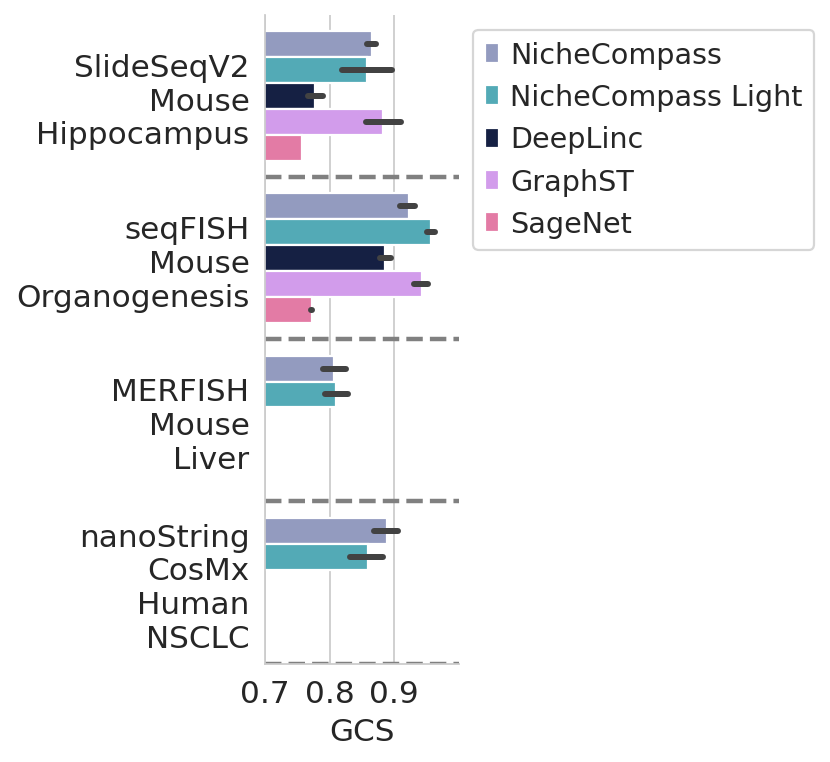

In [78]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_3_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="gcs",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("GCS", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0.7, 0.8, 0.9], fontsize=fontsize)
plt.xlim(0.7, 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_gcs.svg")
plt.show()

In [79]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["gcs"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

gcs    0.980141
dtype: float64

In [80]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["gcs"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

gcs    0.978087
dtype: float64

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/min

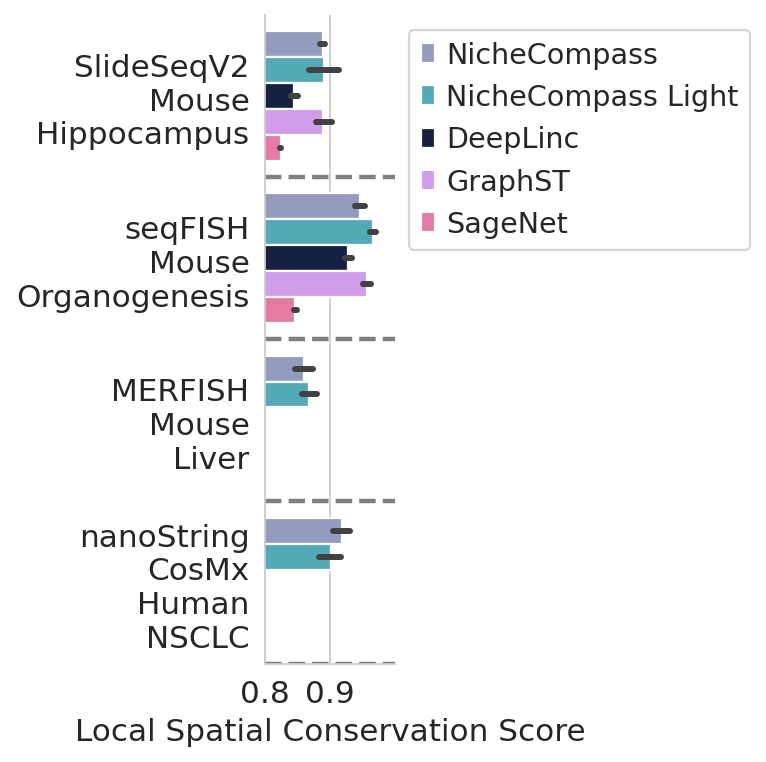

In [81]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_2_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="Local Spatial Conservation Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Local Spatial Conservation Score", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0.8, 0.9], fontsize=fontsize)
plt.xlim(0.8, 1.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_local_spatial_conservation_score.svg")
plt.show()

In [82]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["Local Spatial Conservation Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

Local Spatial Conservation Score    0.999227
dtype: float64

In [83]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Local Spatial Conservation Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

Local Spatial Conservation Score    0.989282
dtype: float64

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/min

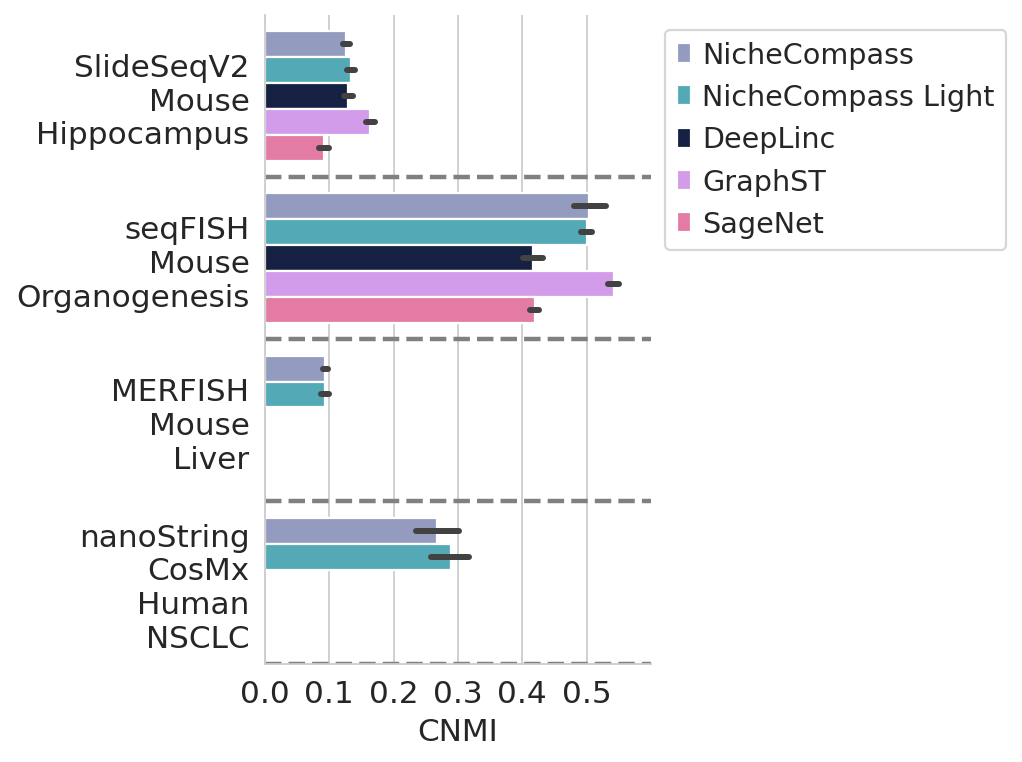

In [84]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_6_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="cnmi",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("CNMI", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=fontsize)
plt.xlim(0., 0.6)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_cnmi.svg")
plt.show()

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/min

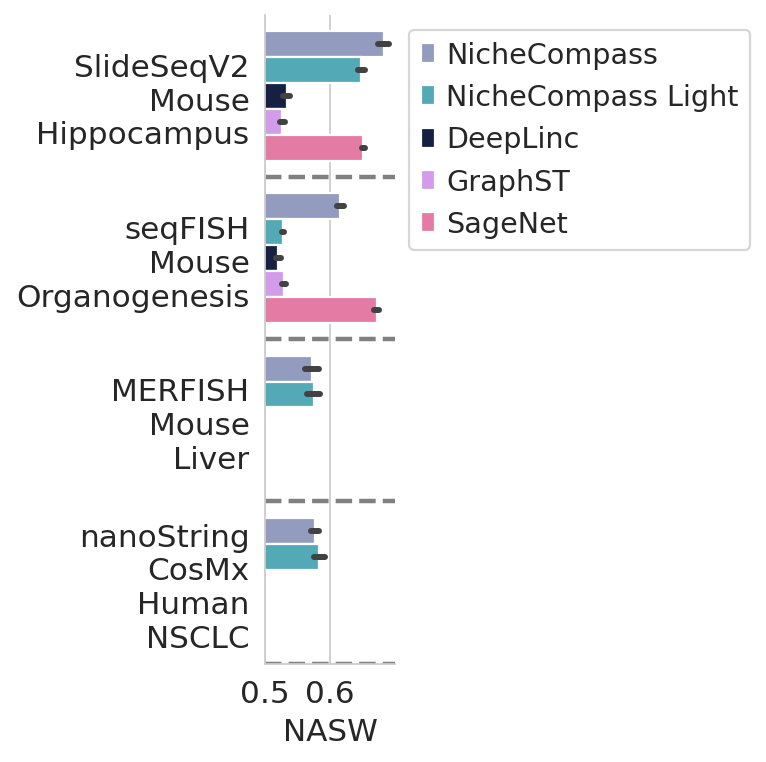

In [88]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_2_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="nasw",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("NASW", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0.5, 0.6], fontsize=fontsize)
plt.xlim(0.5, 0.7)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_nasw.svg")
plt.show()

In [92]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["nasw"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

nasw    1.297056
dtype: float64

In [91]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["nasw"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

nasw    1.164423
dtype: float64

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/min

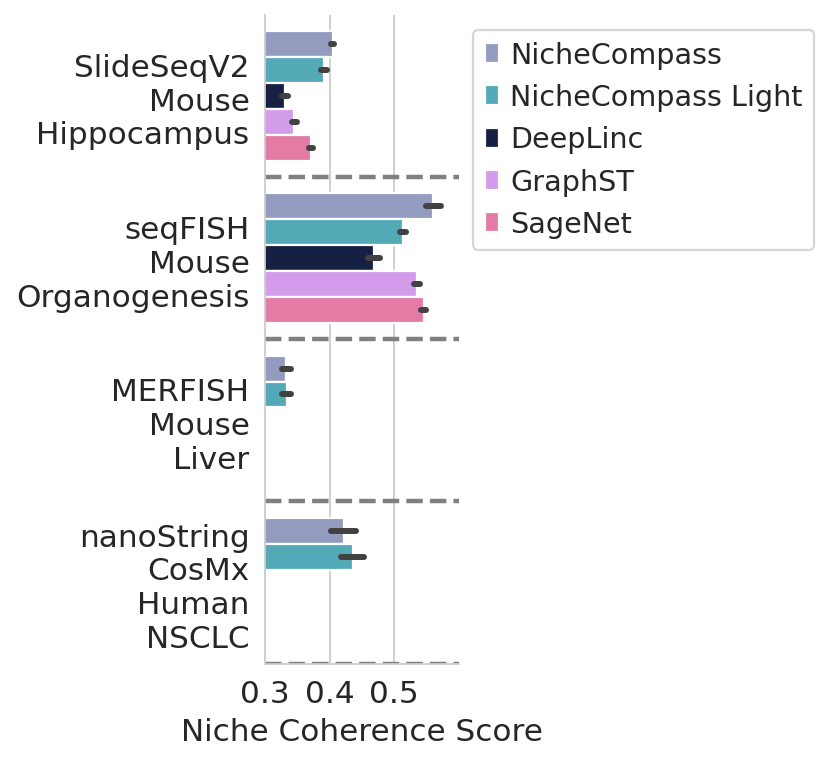

In [97]:
sns.set_style("whitegrid")

model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_3_ticks, 5))
ax = sns.barplot(data=summary_df,
                 x="Niche Coherence Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Niche Coherence Score", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0.3, 0.4, 0.5], fontsize=fontsize)
plt.xlim(0.3, 0.6)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_niche_coherence_score.svg")
plt.show()

In [99]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["Niche Coherence Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

Niche Coherence Score    1.172259
dtype: float64

In [100]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Niche Coherence Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

Niche Coherence Score    1.045571
dtype: float64

/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/home/cartalop/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/cartalop/min

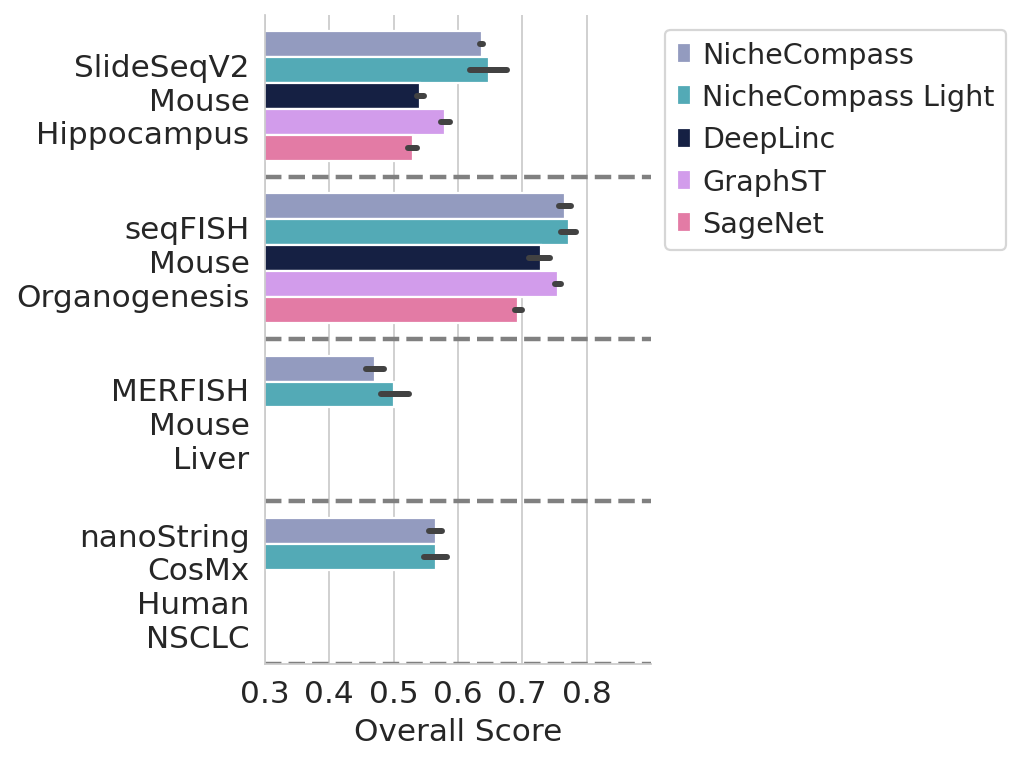

In [102]:
model_palette = {"NicheCompass": "#8C96C6",
                 "NicheCompass Light": "#42B6C7",
                 "DeepLinc": "#0E1C4A",
                 "GraphST": "#D78FF8",
                 "SageNet": "#F46AA2",
                 "scVI": "#FE8B3B",
                 "expiMap": "#7E0028",
                 }

plt.figure(figsize=(fig_width_6_ticks, fig_height))
ax = sns.barplot(data=summary_df,
                 x="Overall Score",
                 y="dataset",
                 hue="model",
                 orient="h",
                 palette=model_palette)
for i in range(summary_df["dataset"].nunique()):
    ax.axhline(0.5 + 1 * i, color='gray', linestyle='--', linewidth=2)

new_labels = [label.get_text().replace(' ', '\n') if i < 3 else label.get_text().replace(' H', '\nH', -1).replace(' N', '\nN', -1).replace(' CosMx', '\nCosMx', -1) for i, label in enumerate(ax.get_yticklabels())]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels(new_labels)
plt.ylabel(None)
plt.xlabel("Overall Score", fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8], fontsize=fontsize)
plt.xlim(0.3, 0.9)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig(f"{benchmarking_folder_path}/benchmarking_barplot_overall_score.svg")
plt.show()

In [103]:
temp_df = summary_df[summary_df["dataset"] == "SlideSeqV2 Mouse Hippocampus"]
metrics_temp_df = temp_df.groupby("model")[["Overall Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

Overall Score    1.097646
dtype: float64

In [104]:
temp_df = summary_df[summary_df["dataset"] == "seqFISH Mouse Organogenesis"]
metrics_temp_df = temp_df.groupby("model")[["Overall Score"]].mean()
metrics_temp_df.iloc[2] / metrics_temp_df.iloc[1] # NC vs GraphST

Overall Score    1.014083
dtype: float64

In [ ]:
# Plot table
plot_metrics_table(
    df=unrolled_df,
    model_col="model",
    model_col_width=2.,
    group_col="dataset",
    metric_cols=category_cols_single_sample, # metric_cols_single_sample,
    metric_col_weights=category_col_weights_single_sample, # metric_col_weights_single_sample,
    metric_col_titles=[col.replace(" ", "\n") for col in category_col_titles_single_sample],
    metric_col_width=1.1, # 0.8,
    plot_width=28, # 32,
    plot_height=8,
    show=True,
    save_dir=benchmarking_folder_path,
    save_name=f"benchmarking_metrics_all_datasets.svg")